In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize 

import warnings
warnings.filterwarnings("ignore")

from myLibraries.queries import * 
from myLibraries.events import *
from myLibraries.theoretical_functions import *

In [2]:
# GLOBAL NOTEBOOK SETTINGS
HOLE_SIZE = 28
YEARS = get_str_years_event()
YEARS.insert(0, "1989")
EVENTS = get_collabs_event() 
EVENTS.insert(0,np.int64(1))
ALL_EVENTS = [e for e in range(1, EVENTS[-1])]

# return the average trajectory for the given hole size and starting publication year
def get_avg_trajectories(events, hole_size, start_y):
    start_y = int(start_y) + 1
    df_y = get_collabs_by_hole_size(hole_size, start_y)
    j=YEARS.index(str(start_y))
        
    x,y = [], []
    for i in df_y:
        if(i!="ID"):
            y.append(df_y[i].mean())
            x.append(events[j])
            j+=1
    
    x.insert(0, events[YEARS.index(str(start_y))-1])
    y.insert(0,1)
    
    return x, y

# **(1) Plot average trajectories**

<center><img src="./assets/0.png" style="width: 1000px;"></center>

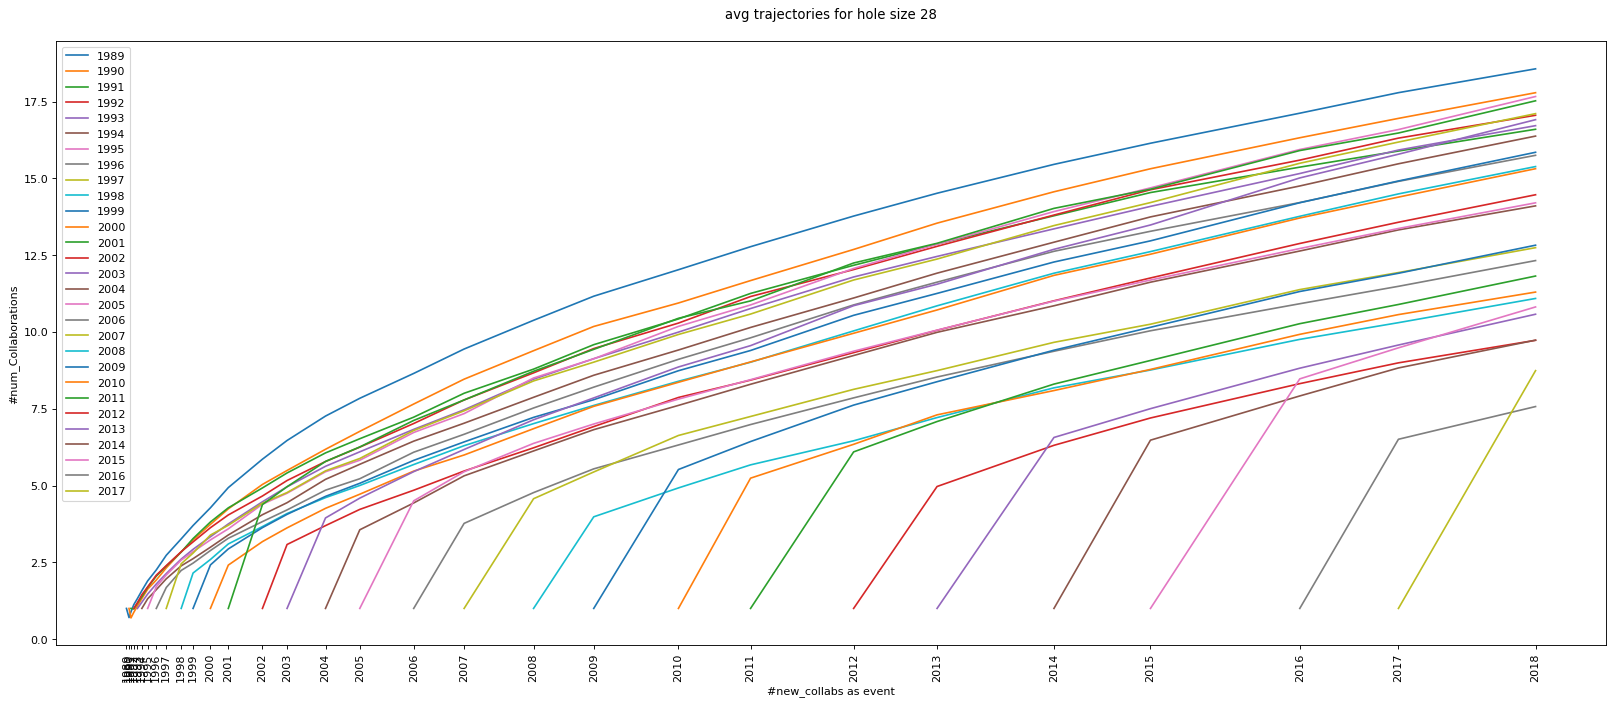

In [3]:
## Plot average trajectories 
plt.figure(figsize=(25, 10), dpi=80)
plt.title("avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

for start_y in YEARS[:-1]:

    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)
    
    if(len(y)==1):
        plt.scatter(x,y)
    else:
        plt.plot(x,y)
    
    plt.xticks(x, y)
    plt.xticks(rotation='vertical')
    
plt.legend(YEARS, loc='upper left')
plt.xticks(EVENTS, YEARS)
plt.show()

# **(2) Plotting fitting function**

<center><img src="./assets/1.jpg" style="width: 1000px;"></center>

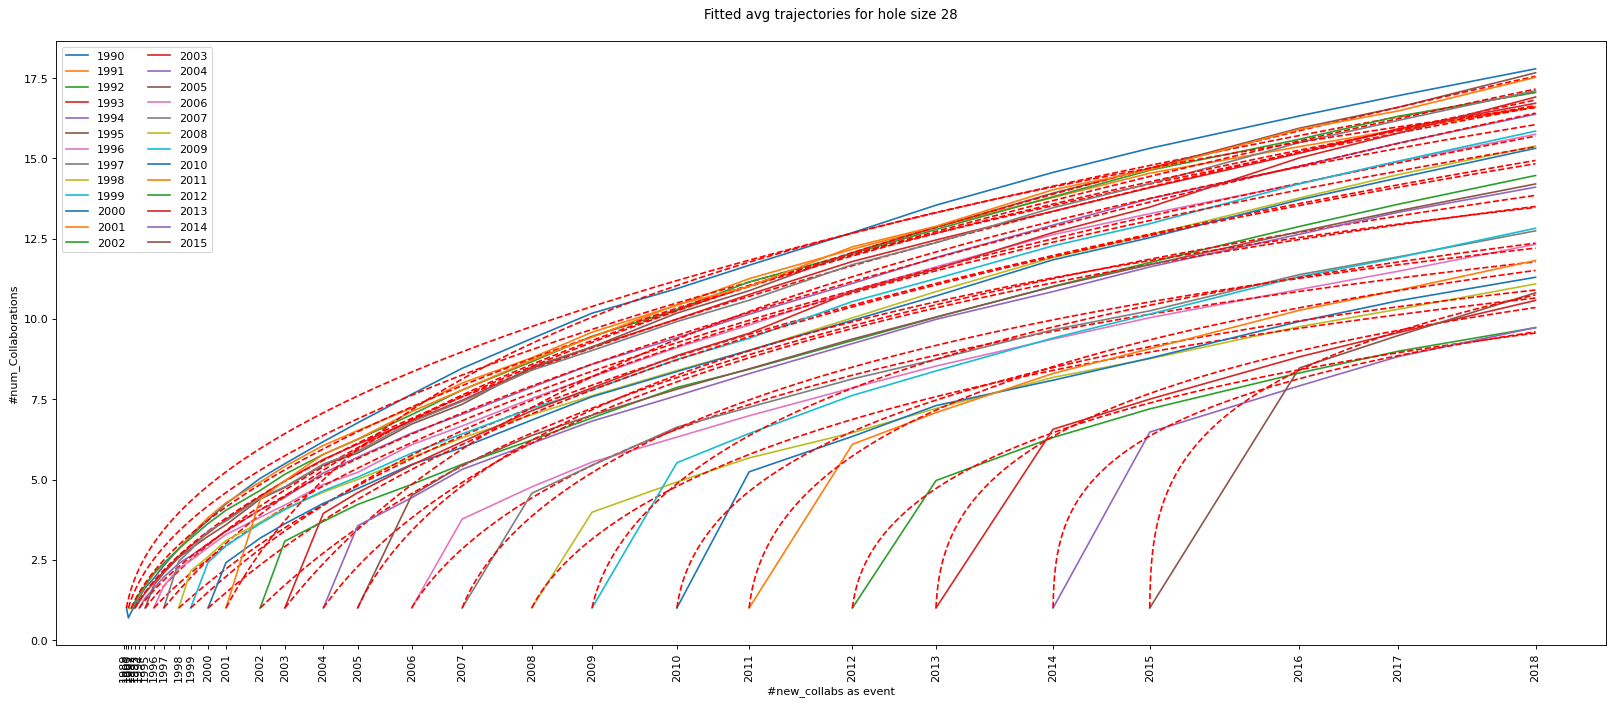

In [4]:
# Theoretichal vertex trajectory for stretched exponential distribution
def theoretical_func(x, a, b, start_x):
    return  pow((a*(np.log(x/start_x)) + 1), b)

# Method to fit the theoretical trajectory to the given average trajectory 
def fit_trajectory(xdata, ydata, start_x):
    
    popt, pcov = curve_fit(lambda x, a, b: theoretical_func(x, a, b, start_x), xdata, ydata, maxfev=5000)
    alpha = popt[0]
    beta = popt[1]

    return theoretical_func(xdata, alpha, beta, np.int64(start_x)), alpha, beta 

## Plot fitted average trjectories

plt.figure(figsize=(25, 10), dpi=80)
plt.title("Fitted avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

alphas = []
betas = []

# get rid of misleading years
YEARS_TO_CONSIDER = YEARS[1: -3]
EVENTS_TO_CONSIDER = EVENTS[1: -3]

for start_y in YEARS_TO_CONSIDER:

    curr_x = EVENTS[YEARS.index(start_y)]  
    
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size)     
    fit_y, alpha, beta = fit_trajectory(x, y, curr_x) # fit the real data above with the theoretical trajectory 
    
    xdata = [a for a in range(x[0], x[-1])]
    fit_y = theoretical_func(xdata, alpha, beta, curr_x)

    # save fitted parameters alpha, beta
    alphas.append(alpha)
    betas.append(beta)
    
    plt.plot(x,y, label=str(start_y))
    plt.plot(xdata, fit_y, 'r--')
    

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=2)
plt.xticks(EVENTS, YEARS)
plt.show()

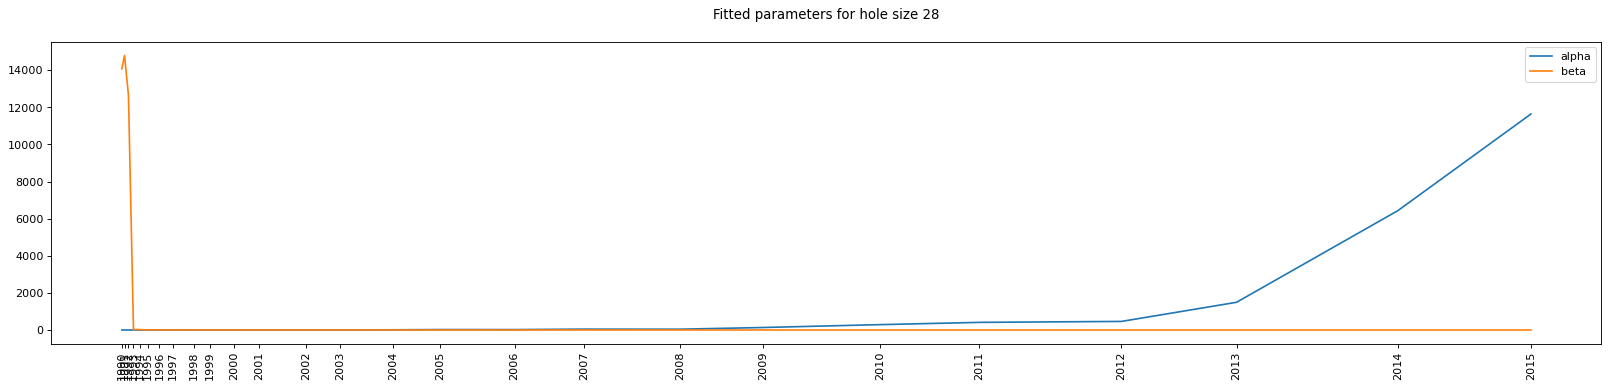

   start_y         alpha          beta
0     1990      0.000032  14076.457167
1     1991      0.000033  14800.306090
2     1992      0.000043  12640.546737
3     1993      0.024583     25.039638
4     1994      0.034846     19.144033
5     1995      0.134304      6.411133
6     1996      0.226642      4.384883
7     1997      0.613738      2.424674
8     1998      0.616213      2.460105
9     1999      0.961775      1.994147
10    2000      1.289748      1.757948
11    2001      6.016925      0.995283
12    2002      3.412457      1.197423
13    2003      5.986260      1.051784
14    2004     10.400754      0.850327
15    2005     23.675097      0.689052
16    2006     22.069618      0.687771
17    2007     46.527831      0.594043
18    2008     42.953624      0.592183
19    2009    133.913805      0.502649
20    2010    288.784363      0.426266
21    2011    411.126583      0.420085
22    2012    462.117358      0.394308
23    2013   1493.526255      0.347990
24    2014   6432.543659 

In [5]:
## Plotting and Printing fitted parameters alpha and beta for each starting year
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted parameters for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.plot(EVENTS_TO_CONSIDER, alphas, label="alpha")
plt.plot(EVENTS_TO_CONSIDER, betas, label="beta")
plt.xticks(EVENTS_TO_CONSIDER, YEARS_TO_CONSIDER)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

print(pd.DataFrame([[YEARS_TO_CONSIDER[i], alphas[i], betas[i]] for i in range(len(alphas))], columns=["start_y", "alpha", "beta"]))

# **(3)** Find **alpha\* and beta\*** to have a function **f\*** minimizing the **errors** 

given a starting event $i$:
- Let $e$ be a generic event
- Let $r_i(e)$ be the function representing the real average trajectory for authors who started to publish at the event $i$
- Let $f_i(e)$ be the fitted function of $r_i(e)$
- Let $f_i^*(e)$ be the general fitting function of which we want to optimized the parameters, for authors who started to publish at the event $i$

#### A) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$
#### B) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$ 

#### C) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 
#### D) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 

In [6]:
## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_A(params, xdata, hole_size):
    opt_alpha, opt_beta = params
    err = 0
    for start_y in YEARS_TO_CONSIDER:
        i = YEARS.index(start_y)
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
            err += pow(abs(theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2)

    sys.stdout.write('\r'+ "optimizing A function with -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_B(params, xdata, hole_size):
    opt_alpha, opt_beta = params
    
    err = 0
    for start_y in YEARS_TO_CONSIDER:
        i = YEARS.index(start_y)
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        
        tmp = []
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
        
            tmp.append(pow(abs(theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2))
        err += np.max(tmp)
    
    sys.stdout.write('\r'+ "optimizing B function with -> params: " + str(params) +", error: "+ str(err))
    return err

SUBSET_SIZE = 200 # the next error function works on all events, choose the number of event to be considered 

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_C(params, xdata, hole_size):
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
        
    err = 0
    for start_y in YEARS_TO_CONSIDER:
        i = YEARS.index(start_y)    
        curr_x = xdata[i]  
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = fit_trajectory(x, y, curr_x) # fit the real data above with the theoretical trajectory 
        

        for e in events_subset:
            if(e>curr_x):
                err += pow(abs(theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - theoretical_func(e, alpha, beta, xdata[i])), 2)

    sys.stdout.write('\r'+ "optimizing C function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_D(params, xdata, hole_size):
    
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
    
    err = 0
    for start_y in YEARS_TO_CONSIDER:
        i = YEARS.index(start_y)
        
        curr_x = xdata[i]  

        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = fit_trajectory(x, y, curr_x) # fit the real data above with the theoretical trajectory 

        tmp = []
        for e in events_subset:
            if(e>curr_x):
                tmp.append(pow(abs(theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - theoretical_func(e, alpha, beta, xdata[i])), 2))
             
        if((len(tmp))!=0):
            err += np.max(tmp)
        
    sys.stdout.write('\r'+ "optimizing D function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err


In [7]:
## optimize alpha* and beta* for each error function defined above 
alphas_opt,betas_opt, errs = [],[],[]

# retrieve alpha* and beta* minimizing the associated function and
    # compute the error made by the optimized parameters 

result_A = minimize(err_f_A, [1, 1], args=(EVENTS, HOLE_SIZE))
fitted_params_A = result_A.x
alphas_opt.append(fitted_params_A[0])
betas_opt.append(fitted_params_A[1])
errs.append(err_f_A(fitted_params_A, EVENTS, HOLE_SIZE))
print()

result_B = minimize(err_f_B, [1, 1], args=(EVENTS, HOLE_SIZE))
fitted_params_B = result_B.x
alphas_opt.append(fitted_params_B[0])
betas_opt.append(fitted_params_B[1])
errs.append(err_f_B(fitted_params_B, EVENTS, HOLE_SIZE))
print()


result_C = minimize(err_f_C, [1, 1], args=(EVENTS, HOLE_SIZE))
fitted_params_C = result_C.x
alphas_opt.append(fitted_params_C[0])
betas_opt.append(fitted_params_C[1])
errs.append(err_f_C(fitted_params_C, EVENTS, HOLE_SIZE))
print()

result_D = minimize(err_f_D, [1, 1], args=(EVENTS, HOLE_SIZE))
fitted_params_D = result_D.x
alphas_opt.append(fitted_params_D[0])
betas_opt.append(fitted_params_D[1])
errs.append(err_f_D(fitted_params_D, EVENTS, HOLE_SIZE))
print()

print()
print(pd.DataFrame([[errs[i], alphas_opt[i], betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_B", "err_f_C", "err_f_D"], ["ERROR", "alpha", "beta",]))

optimizing A function with -> params: [20.63798896  0.54052556], error: 4665.929920012973

KeyboardInterrupt: 

In [15]:
## get general fitting functions by starting year for each couple of parameter found above 
error_f_labels = ["A", "B", "C", "D"] 
error_fit_functions = {}

for i in range(len(error_f_labels)):
    # get general error fitted functions by starting year
    functions_by_start_y = [] # contains fitted error functions for each year 
    for start_y in YEARS_TO_CONSIDER:
        curr_x = EVENTS[YEARS.index(start_y)]  
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
        
        xdata = [e for e in range(x[0], x[-1])] # xdata is the list of events
        general_fit_y = theoretical_func(xdata, alphas_opt[i], betas_opt[i], curr_x)
        functions_by_start_y.append(general_fit_y)
    
    error_fit_functions[error_f_labels[i]] = functions_by_start_y

# **(4) Shift fitted trajectories, compute their average and fit it**

<center><img src="./assets/4.png" style="width: 600px;"></center>

In [8]:
# Shift all fitted trajectories
shifted_funcs = []
since = 0

#don't consider the  last 5 years (averages sucks)
for i in range(since, len(alphas)):
    f = theoretical_func(ALL_EVENTS, alphas[i], betas[i], np.int64(1))
    shifted_funcs.append(f) # add function to the set

In [9]:
# compute the average of the shifted functions
avg_shift = np.average(np.array(shifted_funcs), axis=0)

In [10]:
# fit the average curve
fit_avg_shift , alpha, beta = fit_trajectory(ALL_EVENTS, avg_shift,  np.int64(1)) 

print("The fitted parameters are:")
print(" alpha*:", alpha, "\n beta*:", beta)

The fitted parameters are:
 alpha*: 0.016581355065366486 
 beta*: 28.62645755948666


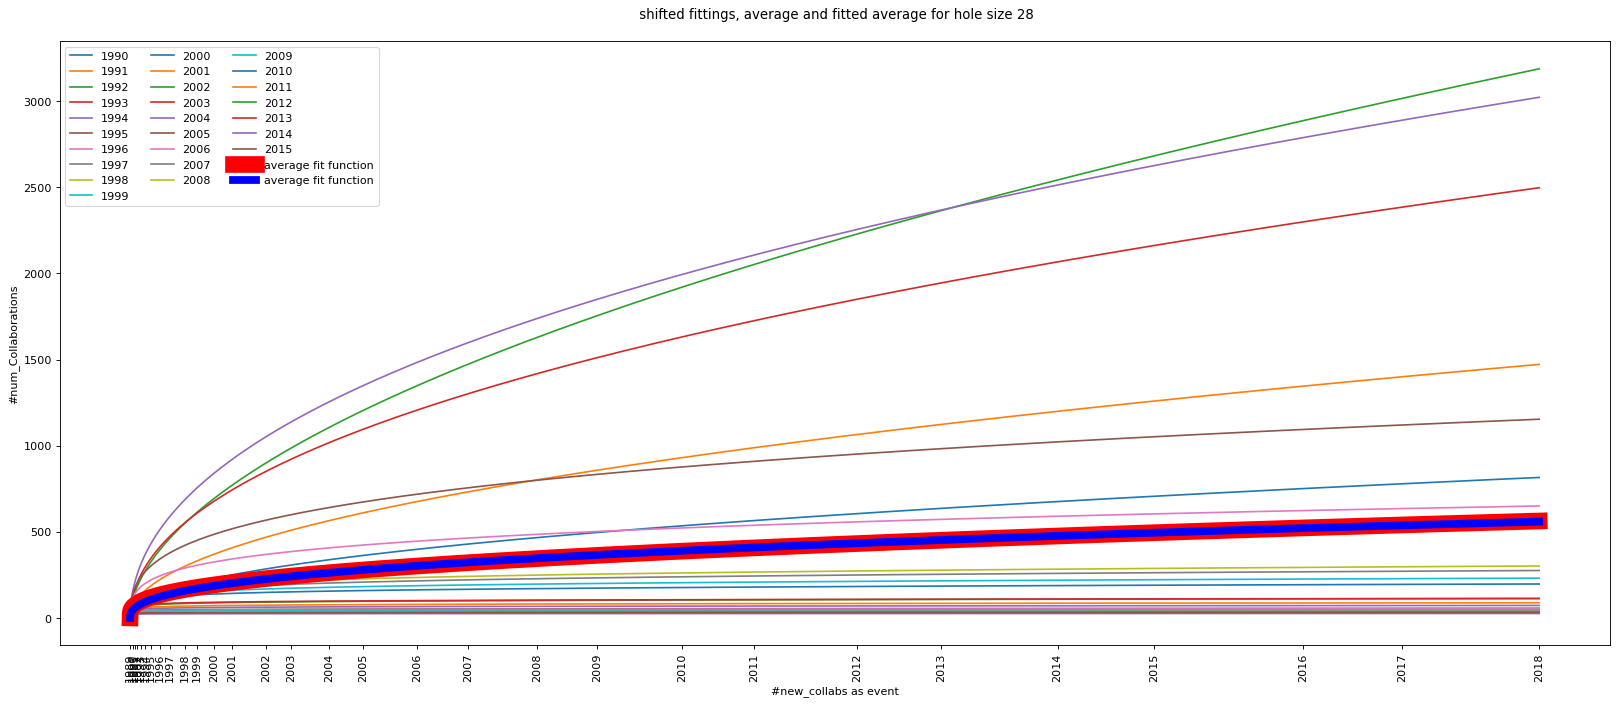

In [11]:
plt.figure(figsize=(25, 10), dpi=80)
plt.title(" shifted fittings, average and fitted average for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

j = 0
for start_y in YEARS_TO_CONSIDER[since:]:
    plt.plot(ALL_EVENTS,shifted_funcs[j], label=start_y)
    j = j+1    
    
    
plt.plot(ALL_EVENTS, avg_shift, 'r-+', label="average fit function",  linewidth=15.0)
plt.plot(ALL_EVENTS, fit_avg_shift, 'b-', label="average fit function", linewidth=7.0)

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=3)
plt.xticks(EVENTS, YEARS)
plt.show()

In [12]:
## get general fitting functions for each starting year for alpha* and beta* of the fitted average
average_fit_functions = [] # contains fitted error functions for each year 
for start_y in YEARS_TO_CONSIDER:
    curr_x = EVENTS[YEARS.index(start_y)]  
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
    xdata = [e for e in range(x[0],x[-1])]
    
    general_fit_y = theoretical_func(xdata, alpha, beta, np.int64(curr_x))
    average_fit_functions.append(general_fit_y)


# **(5) compare general fitting error functions A,B,C and D with the general average fitted one**  

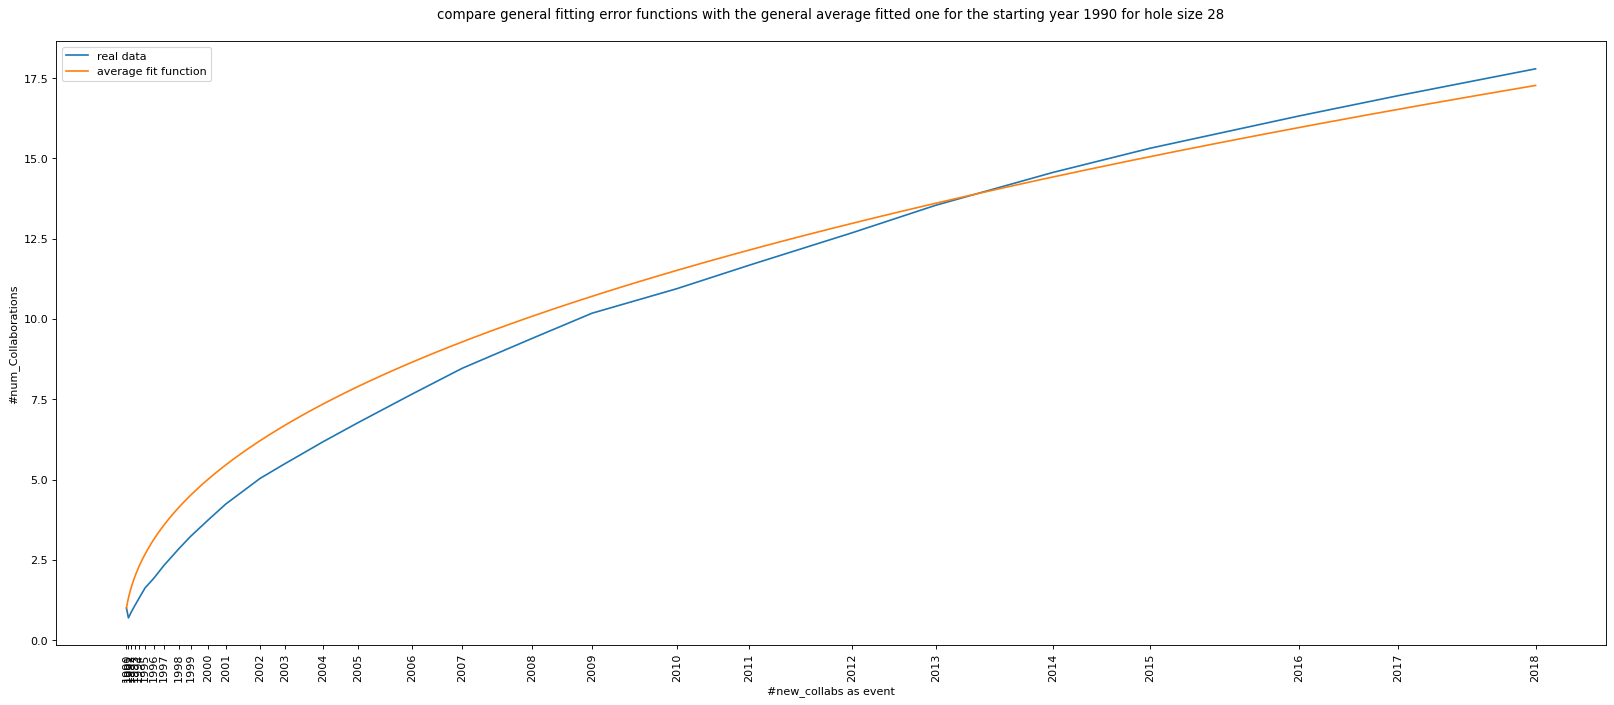

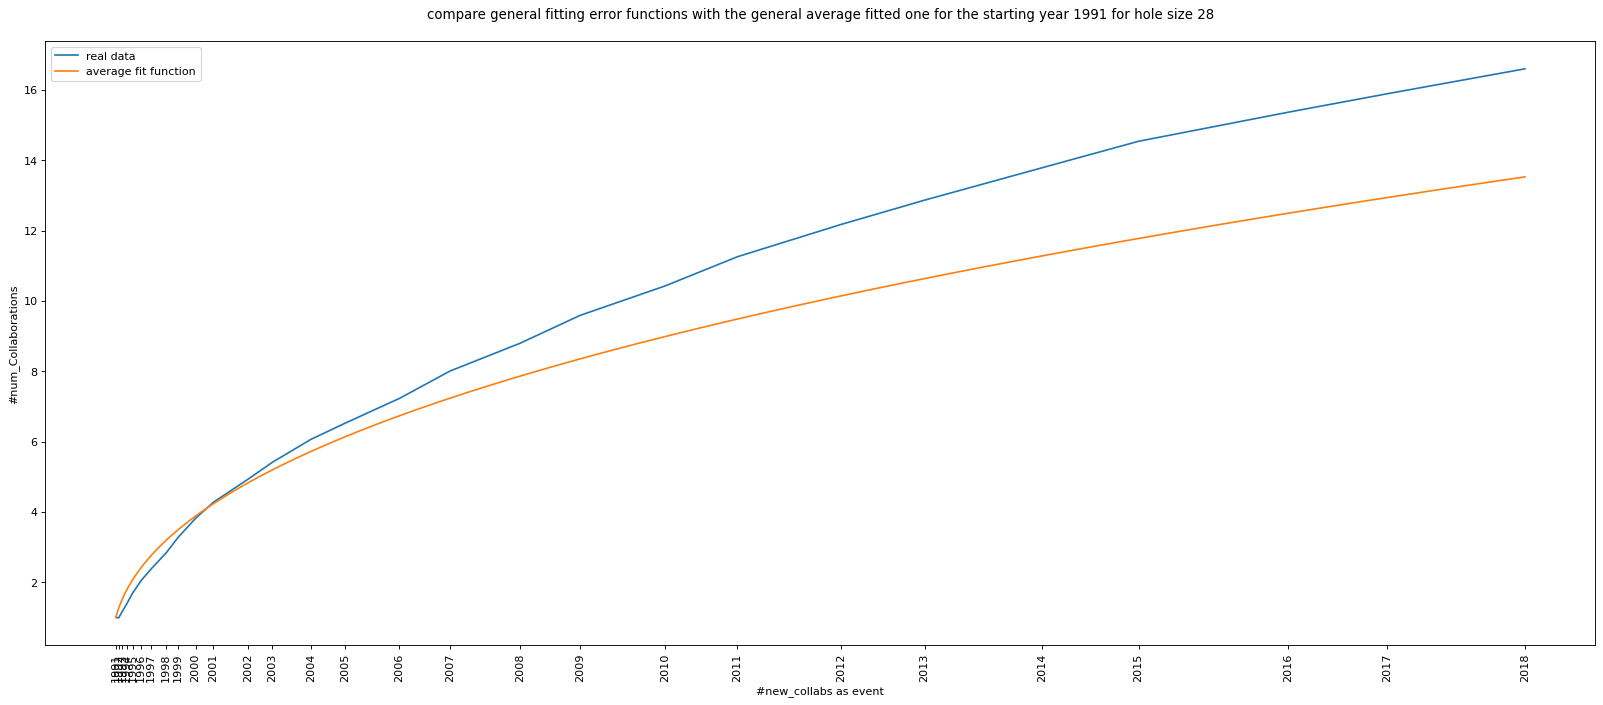

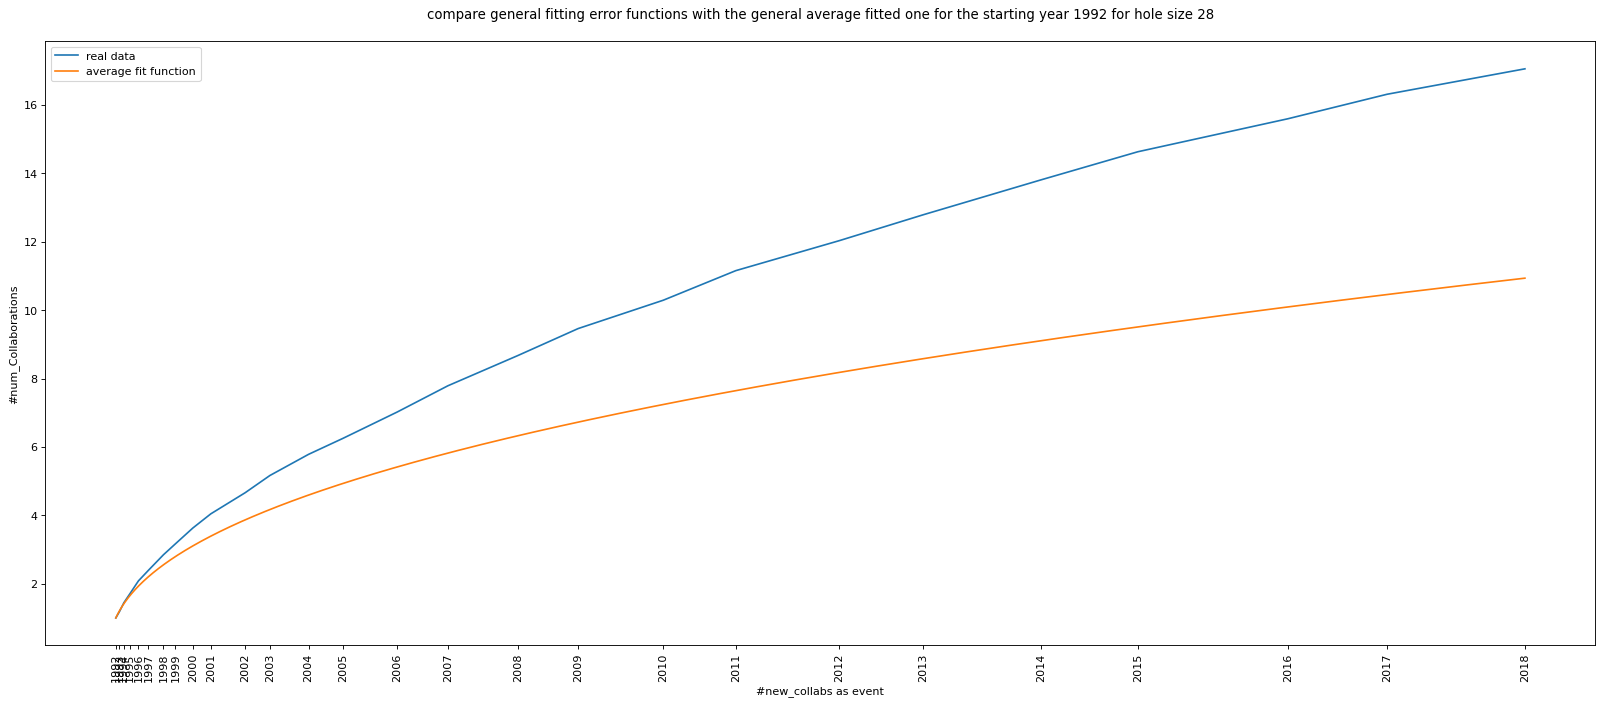

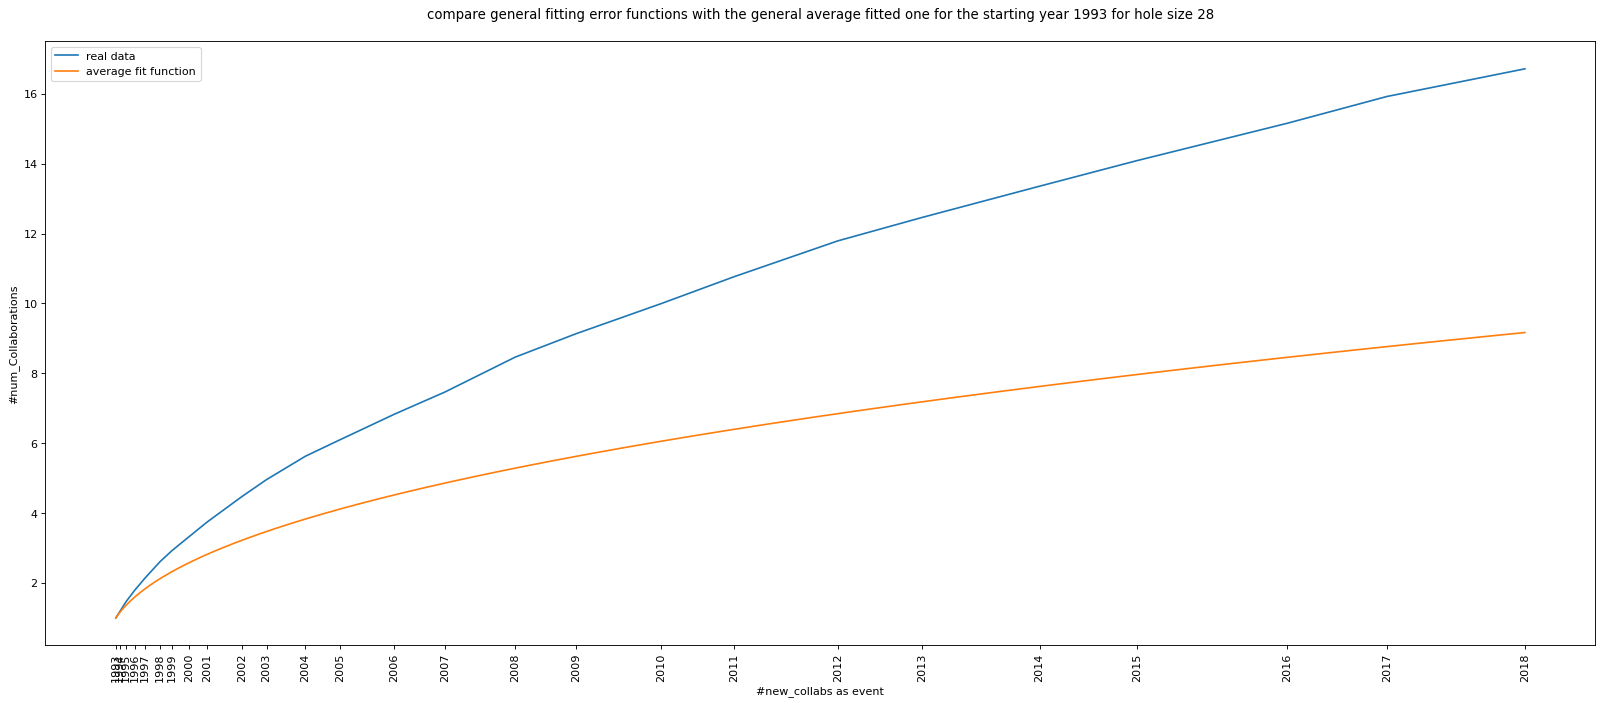

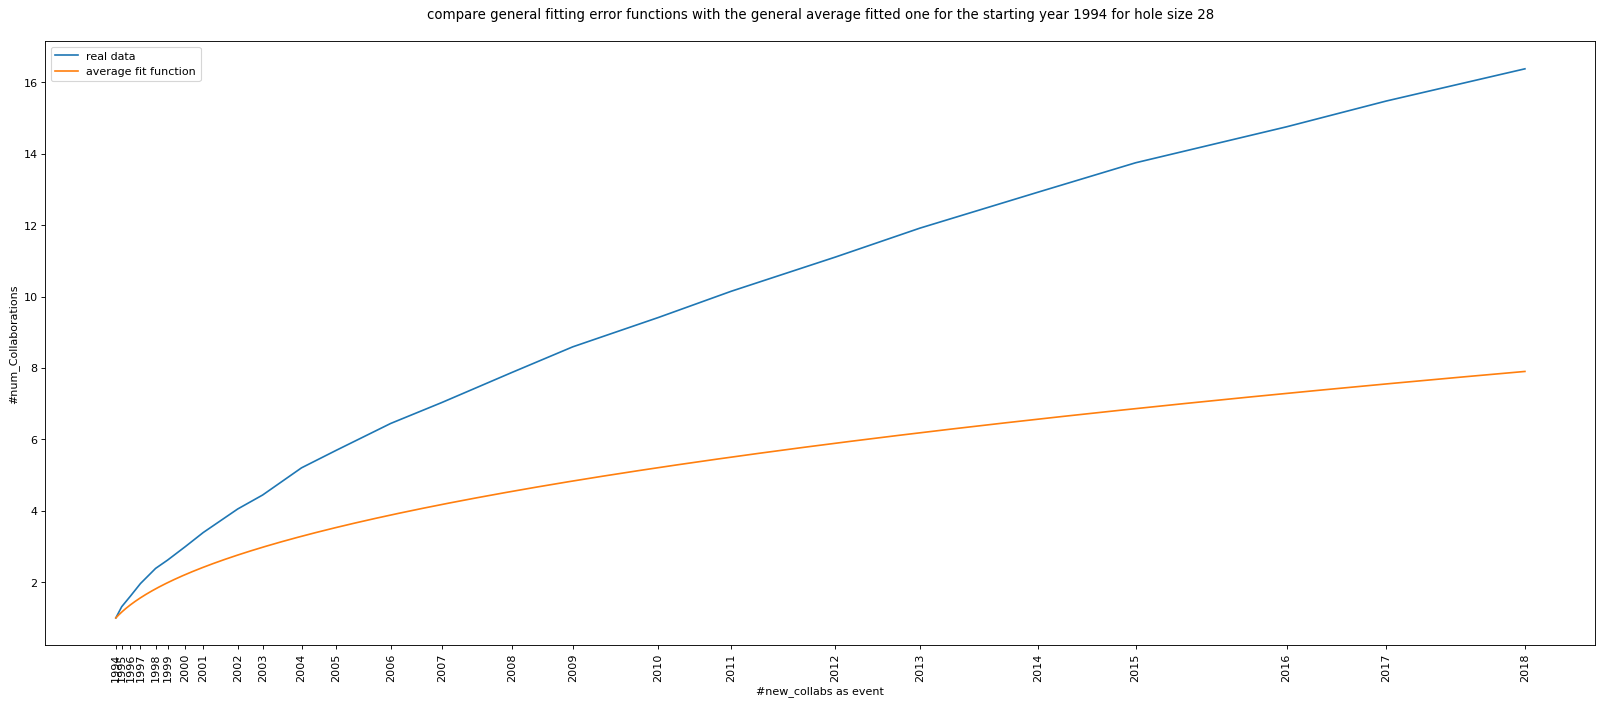

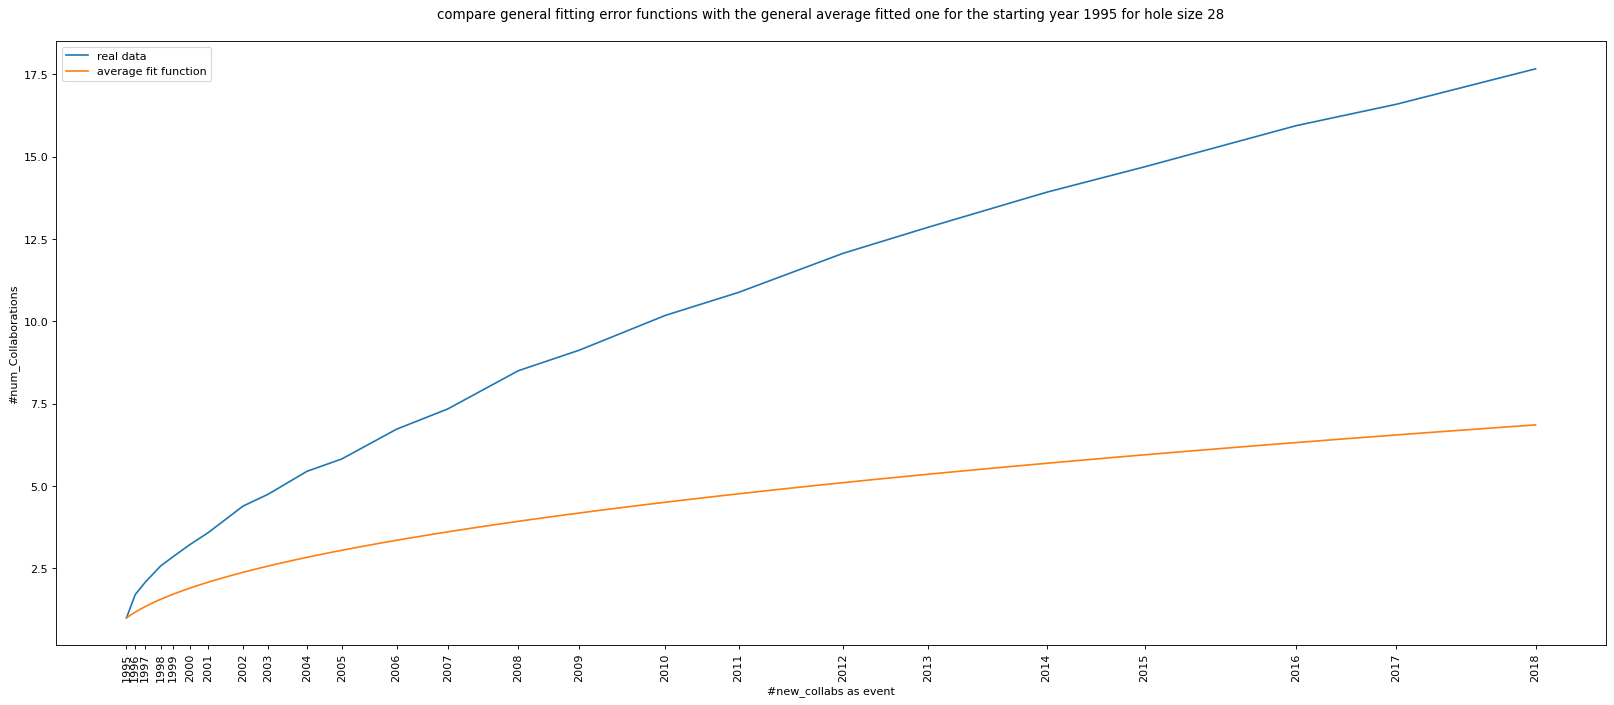

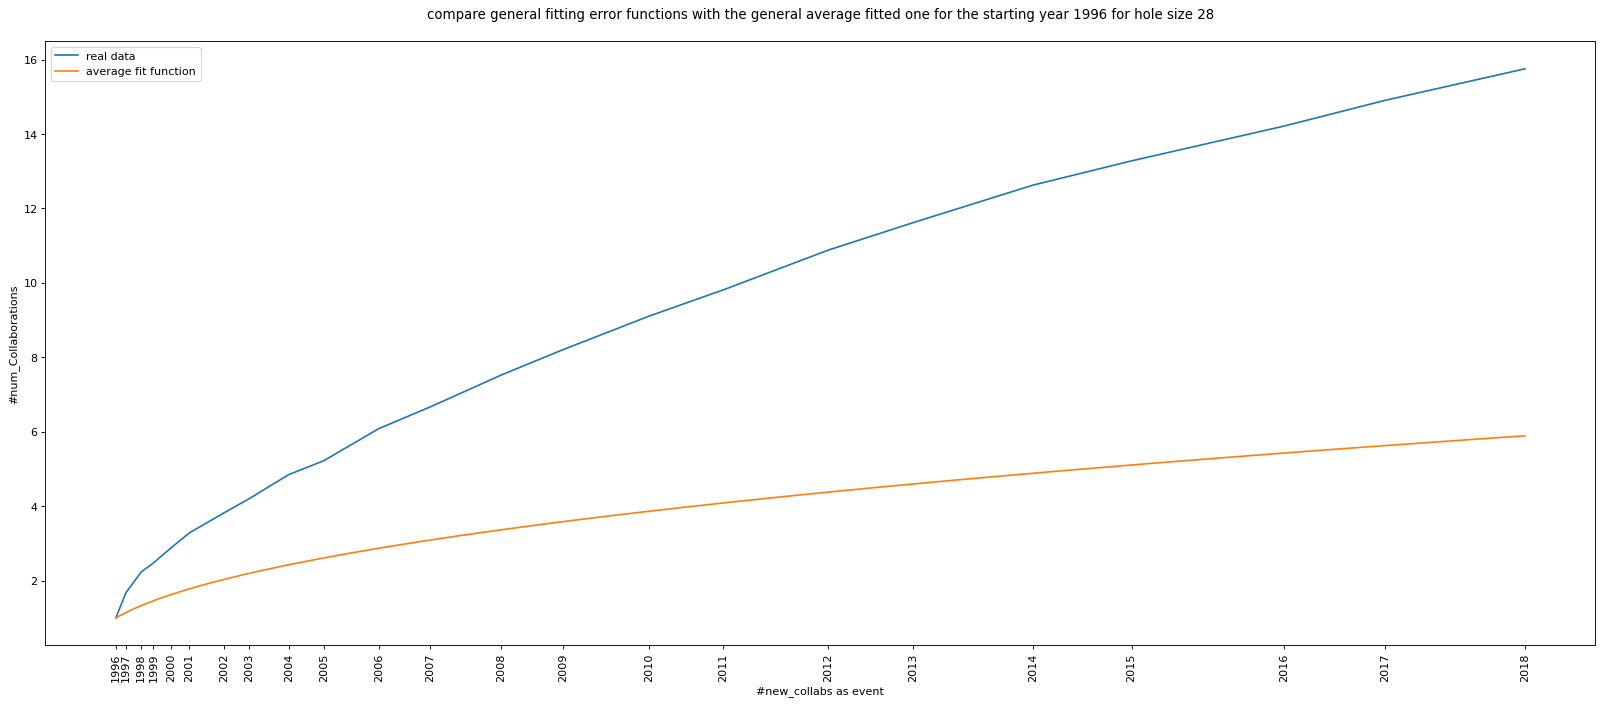

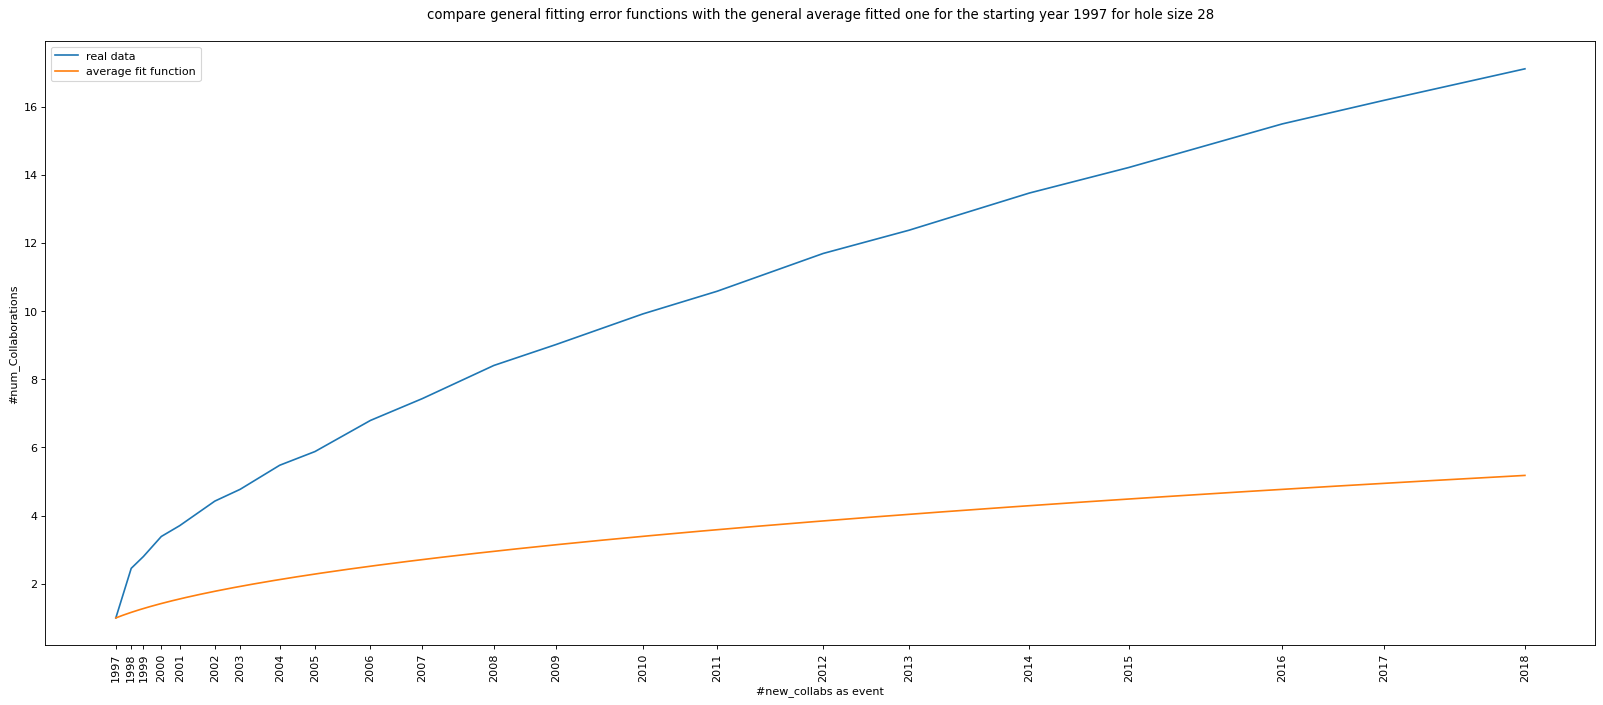

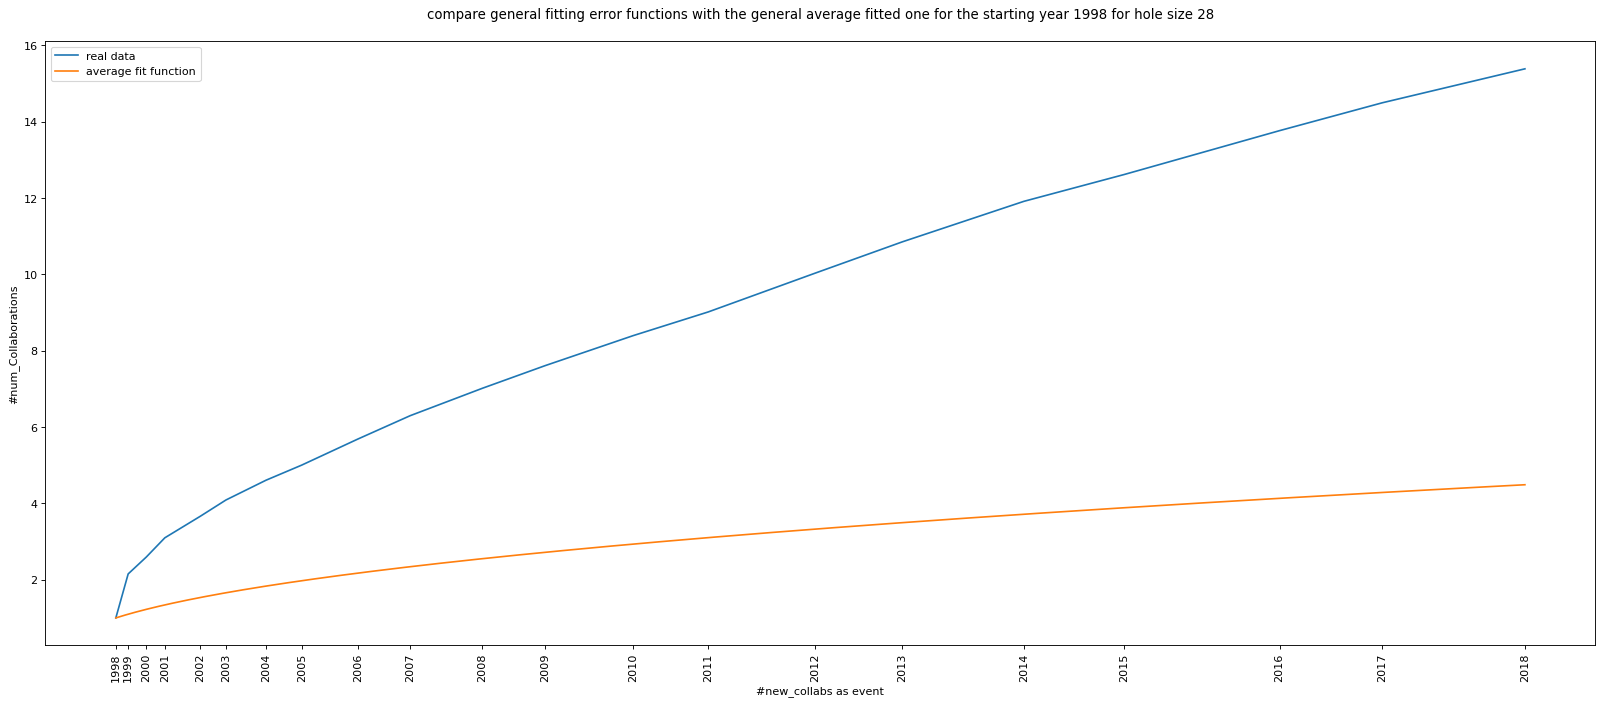

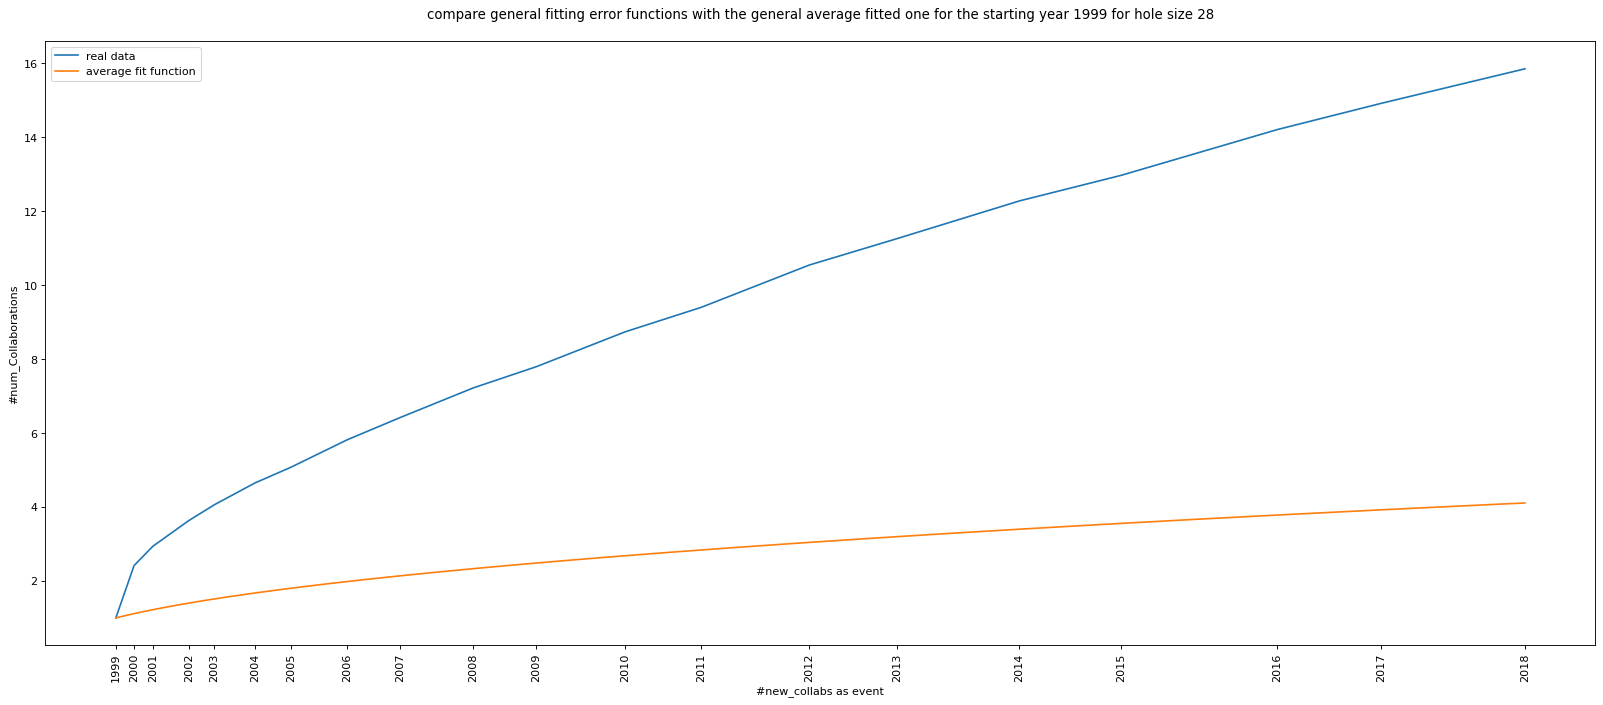

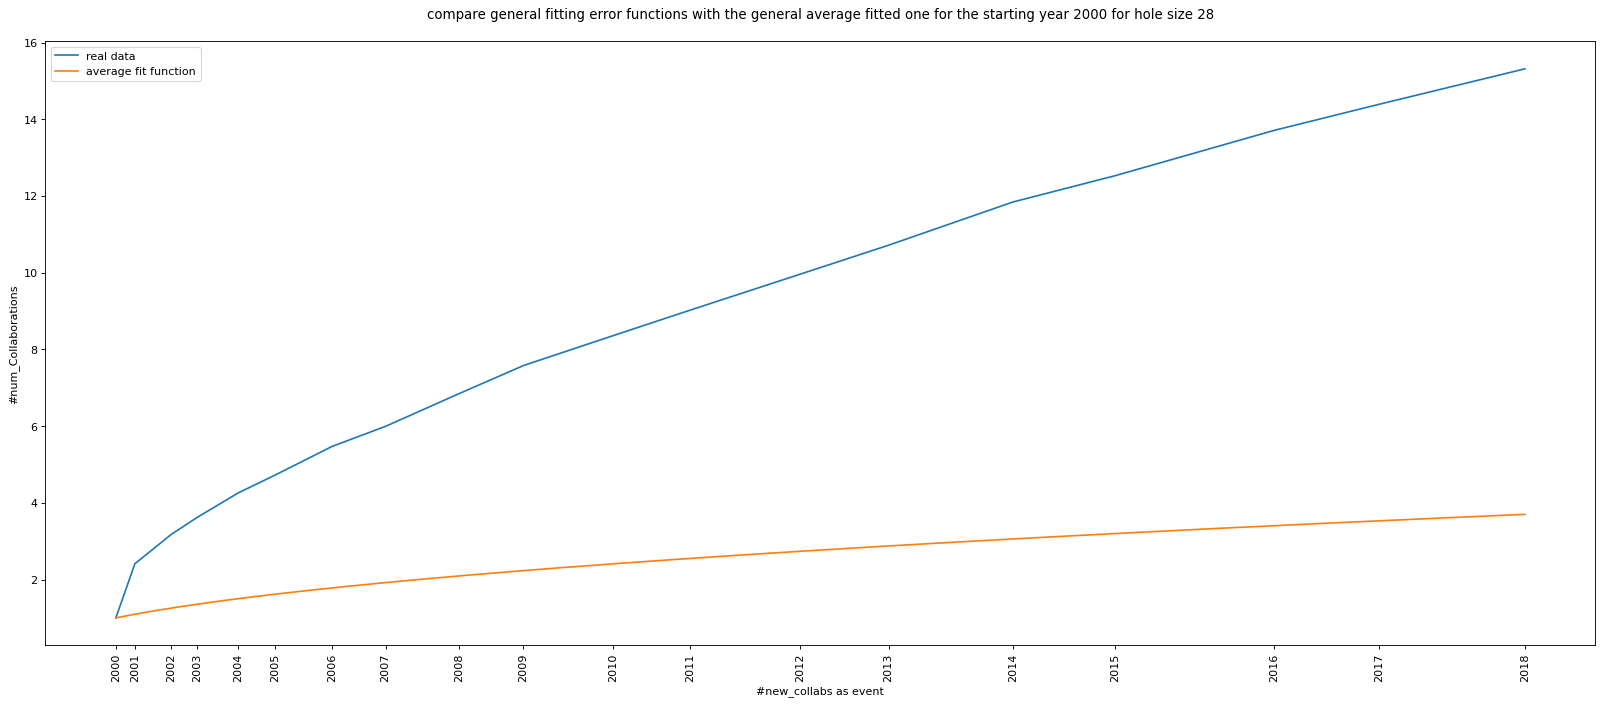

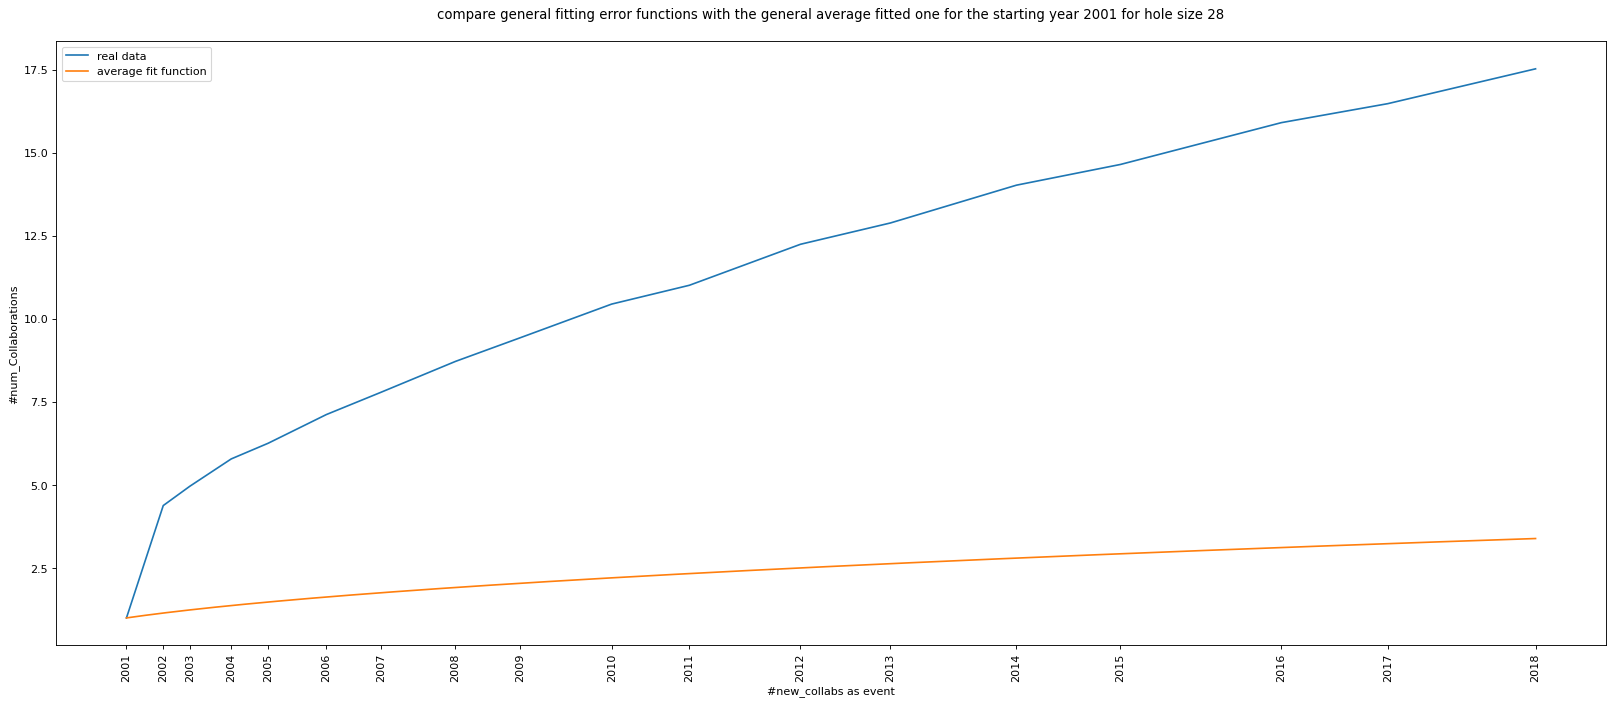

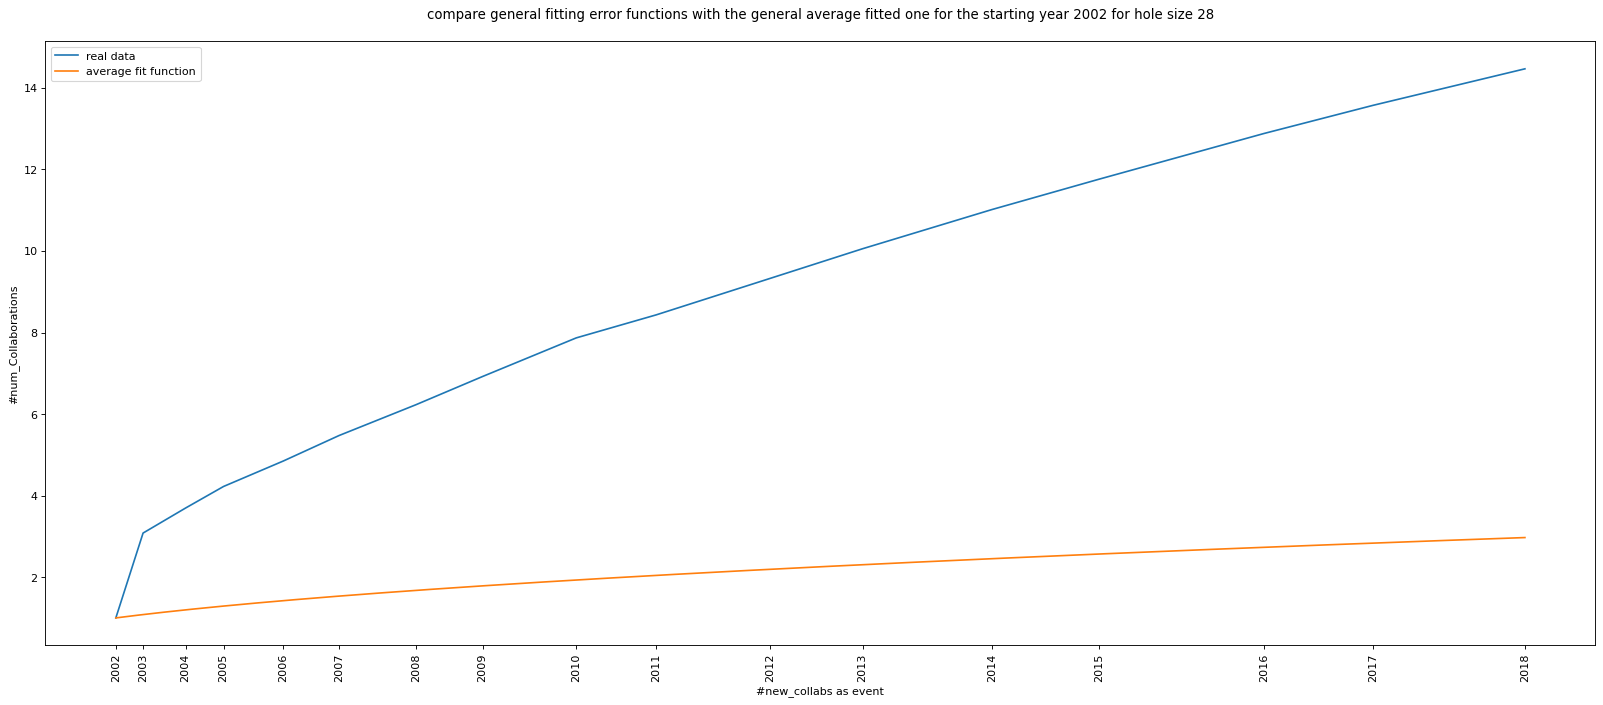

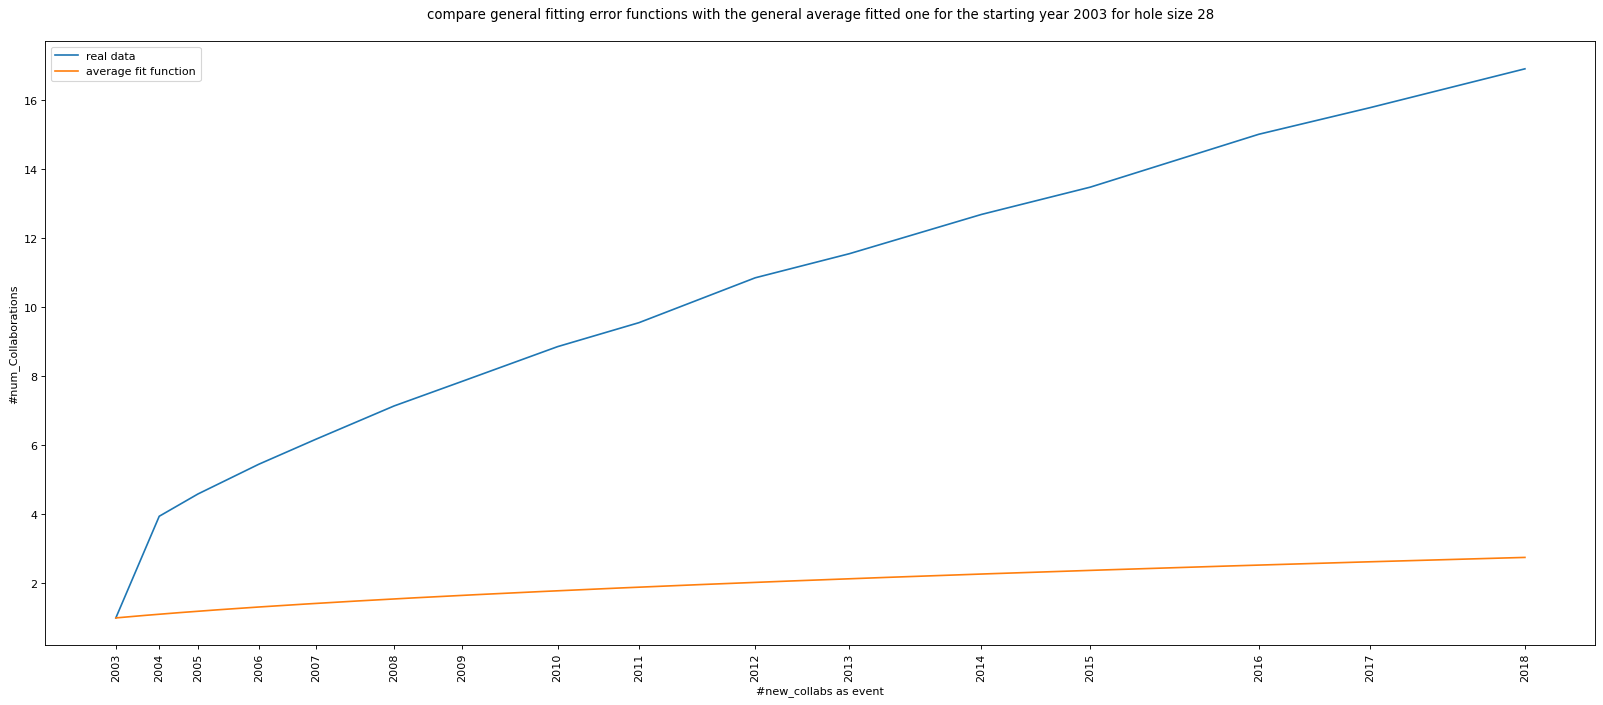

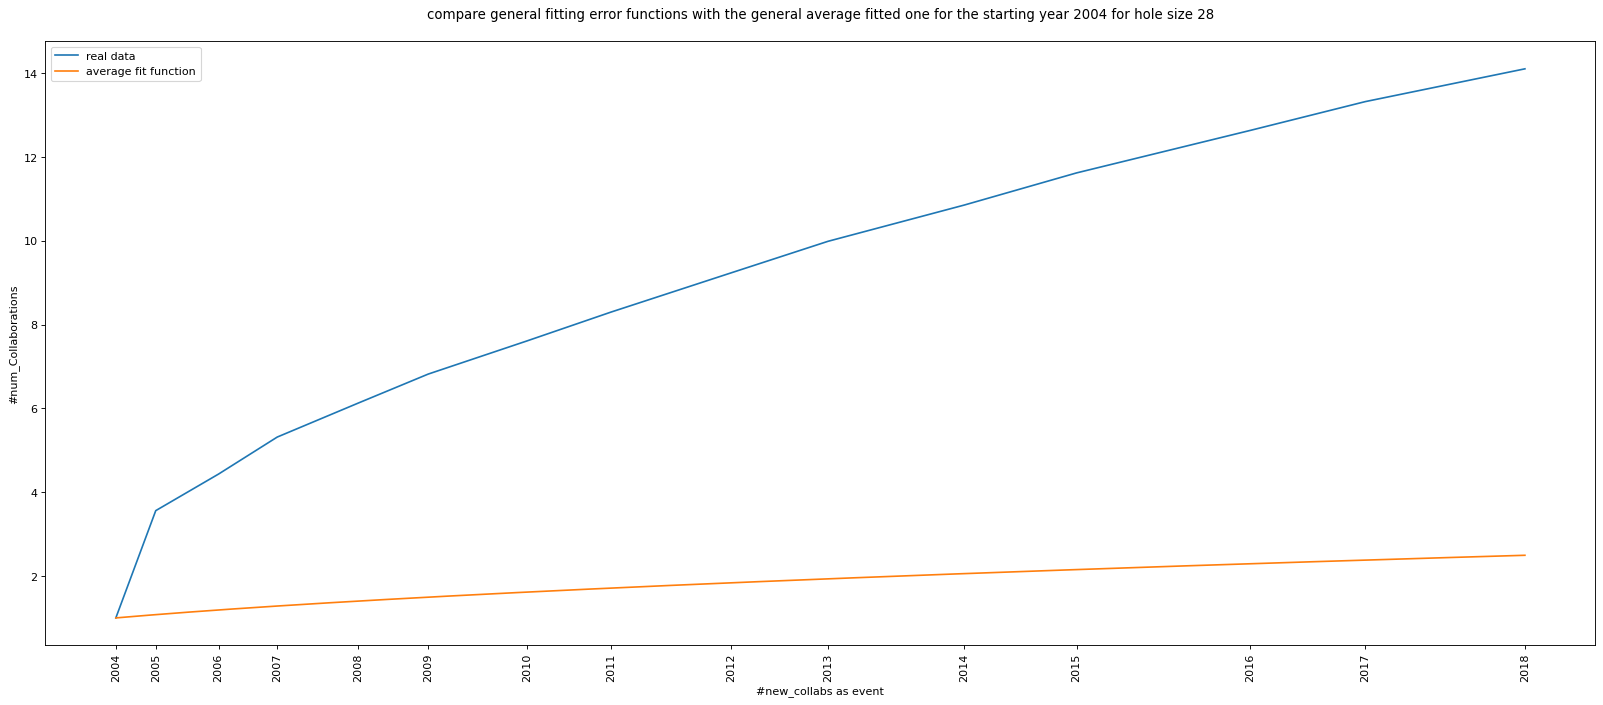

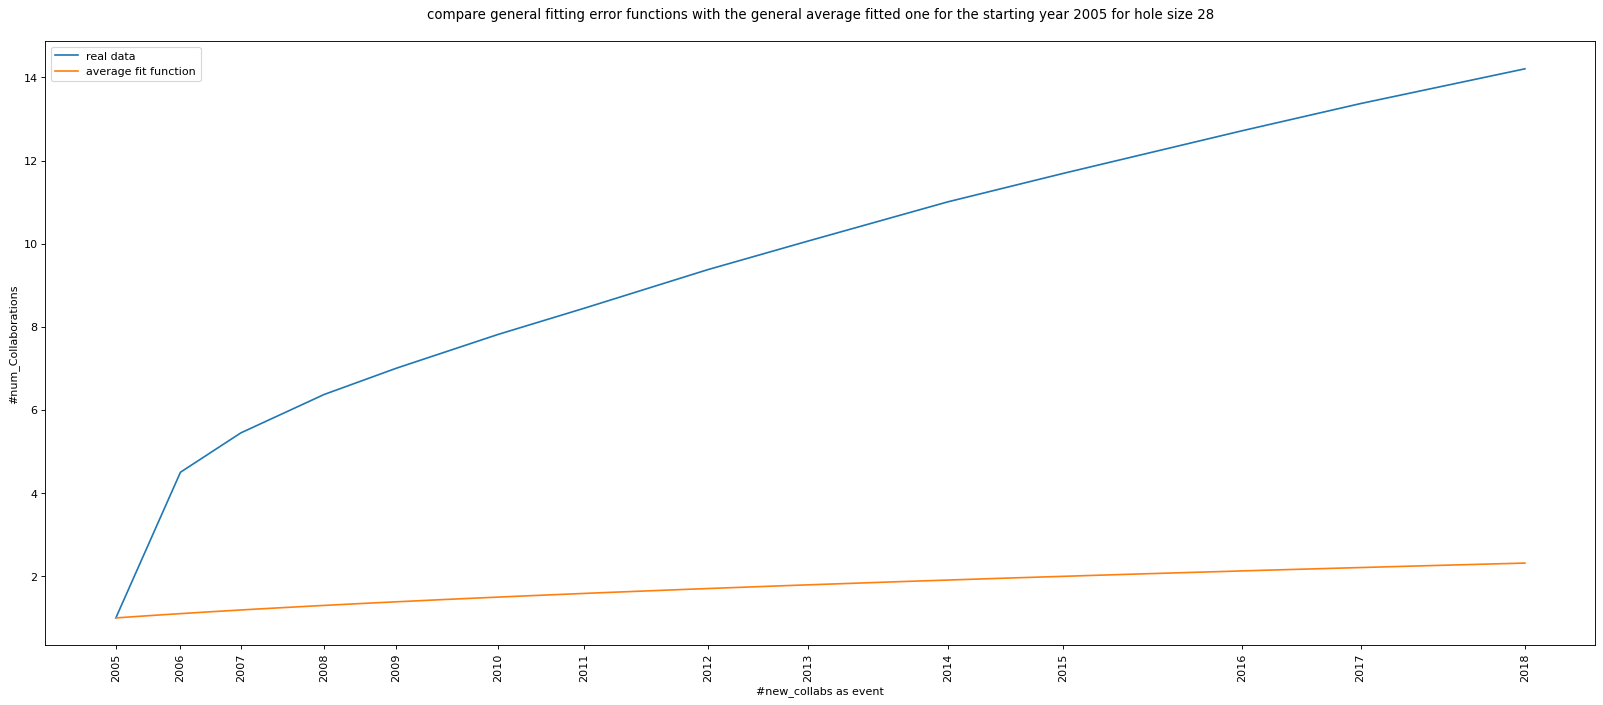

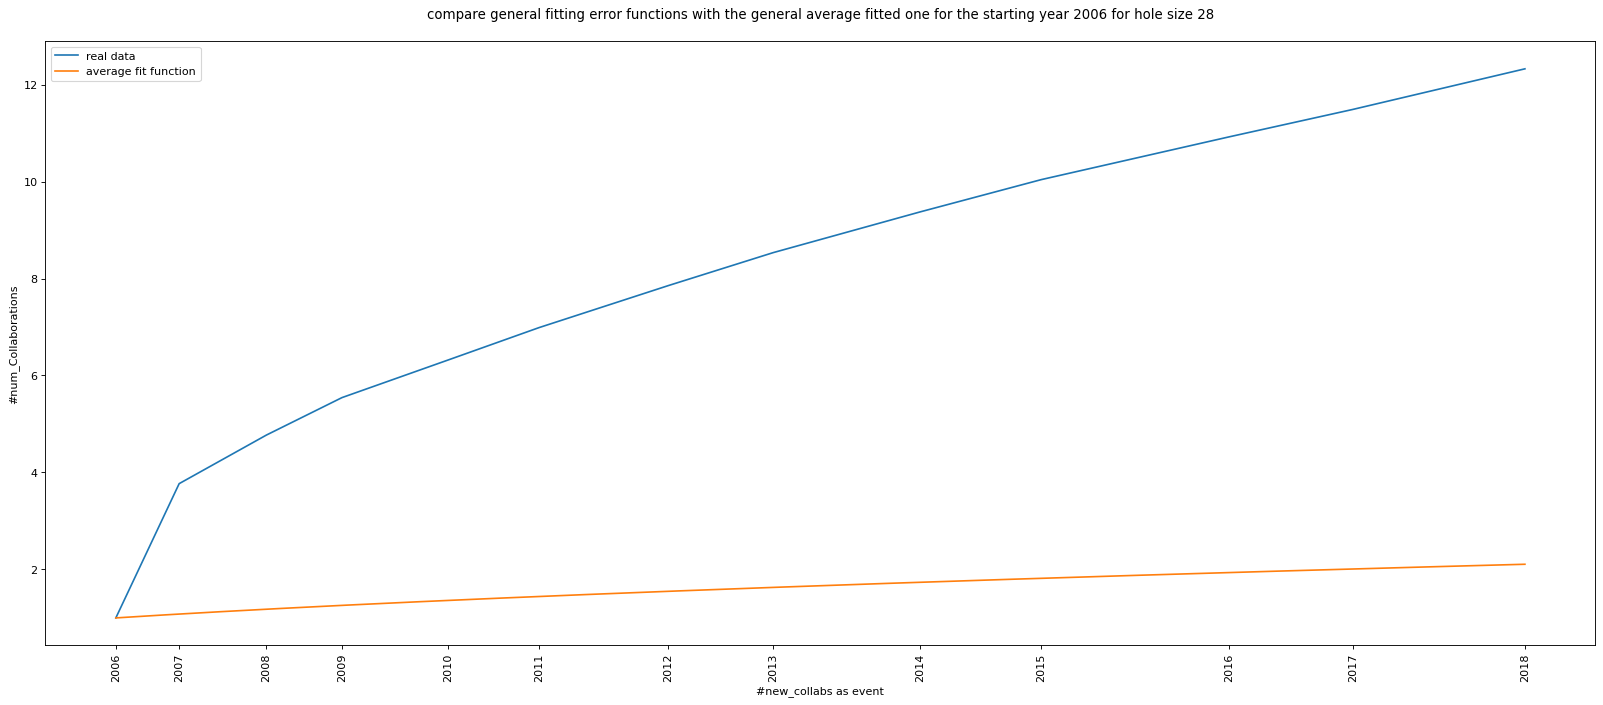

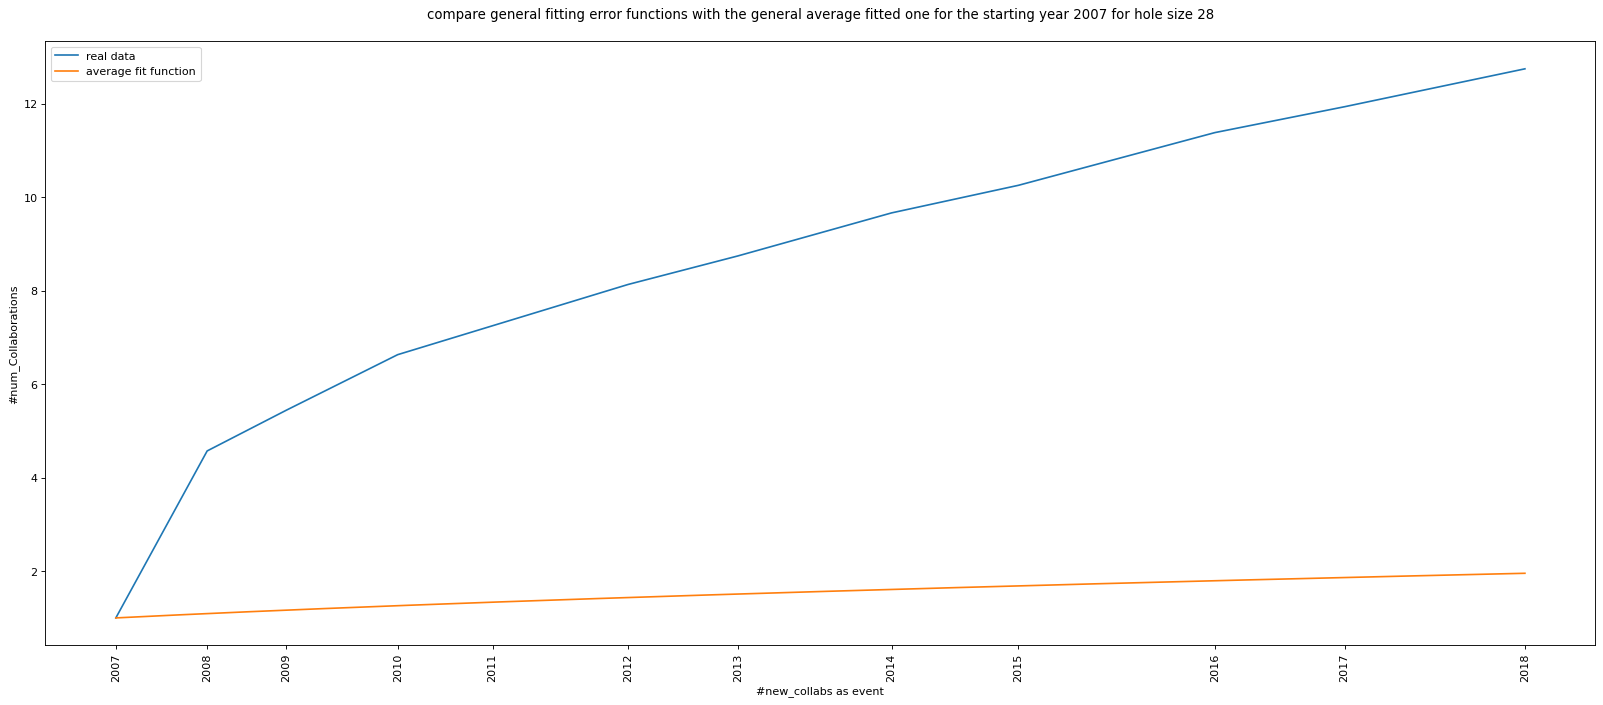

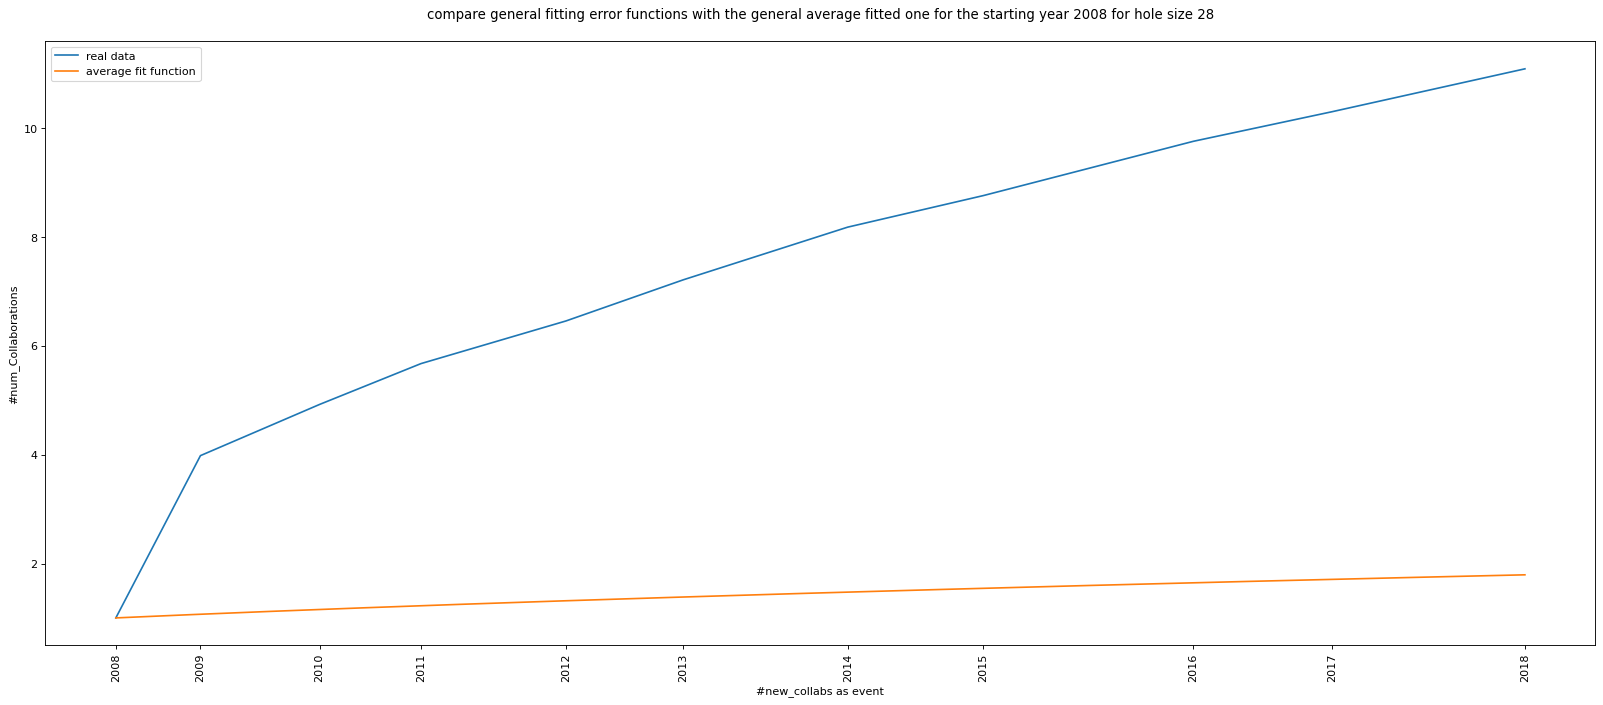

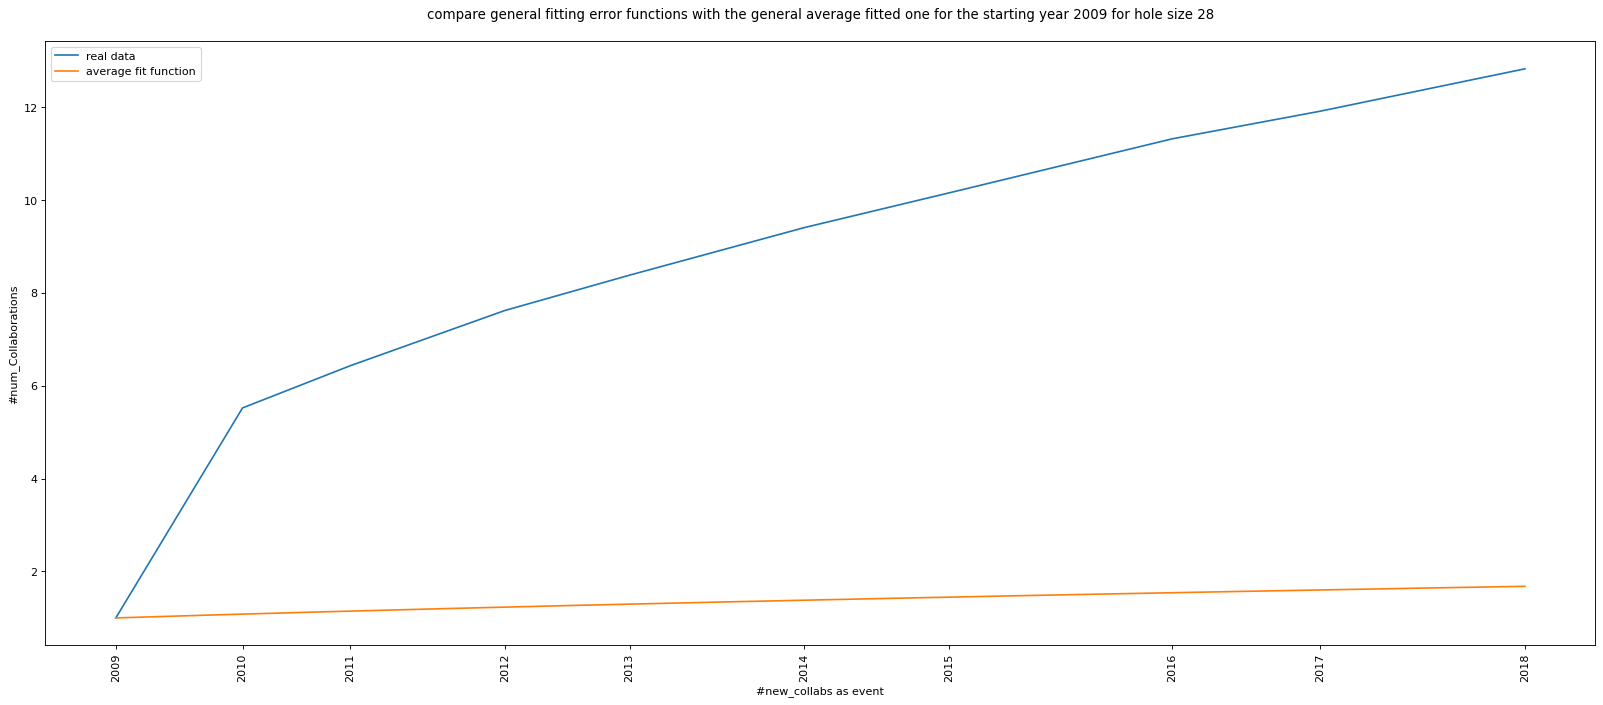

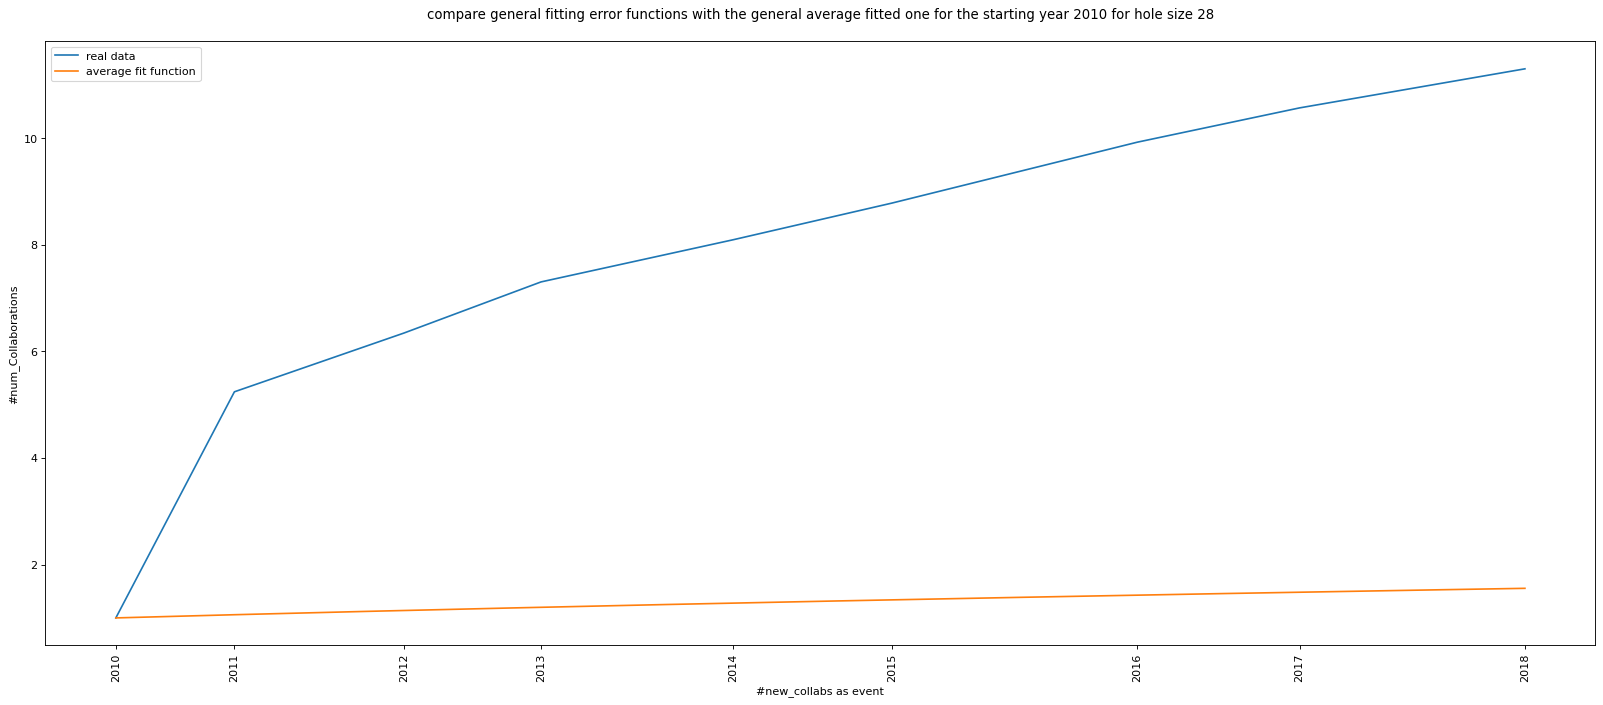

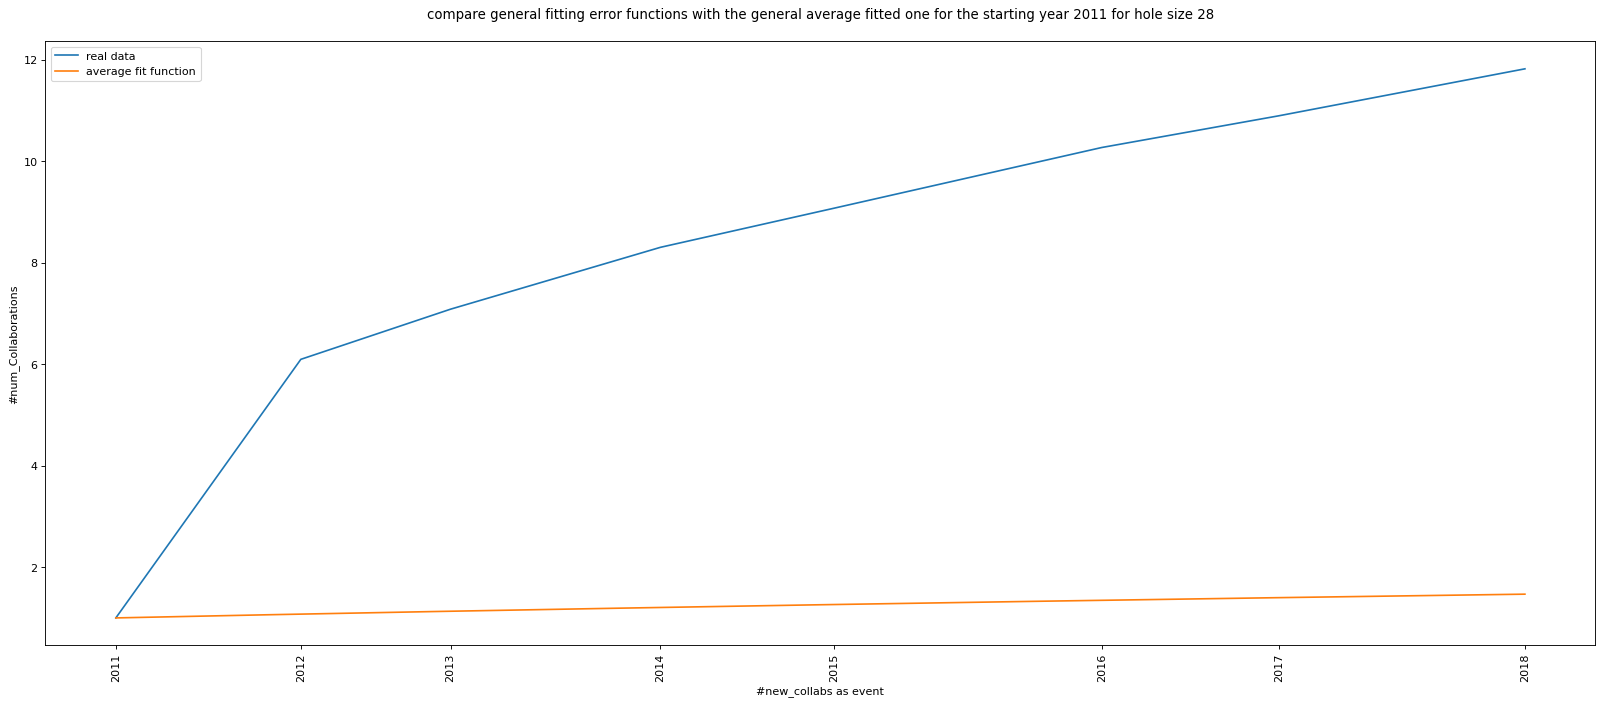

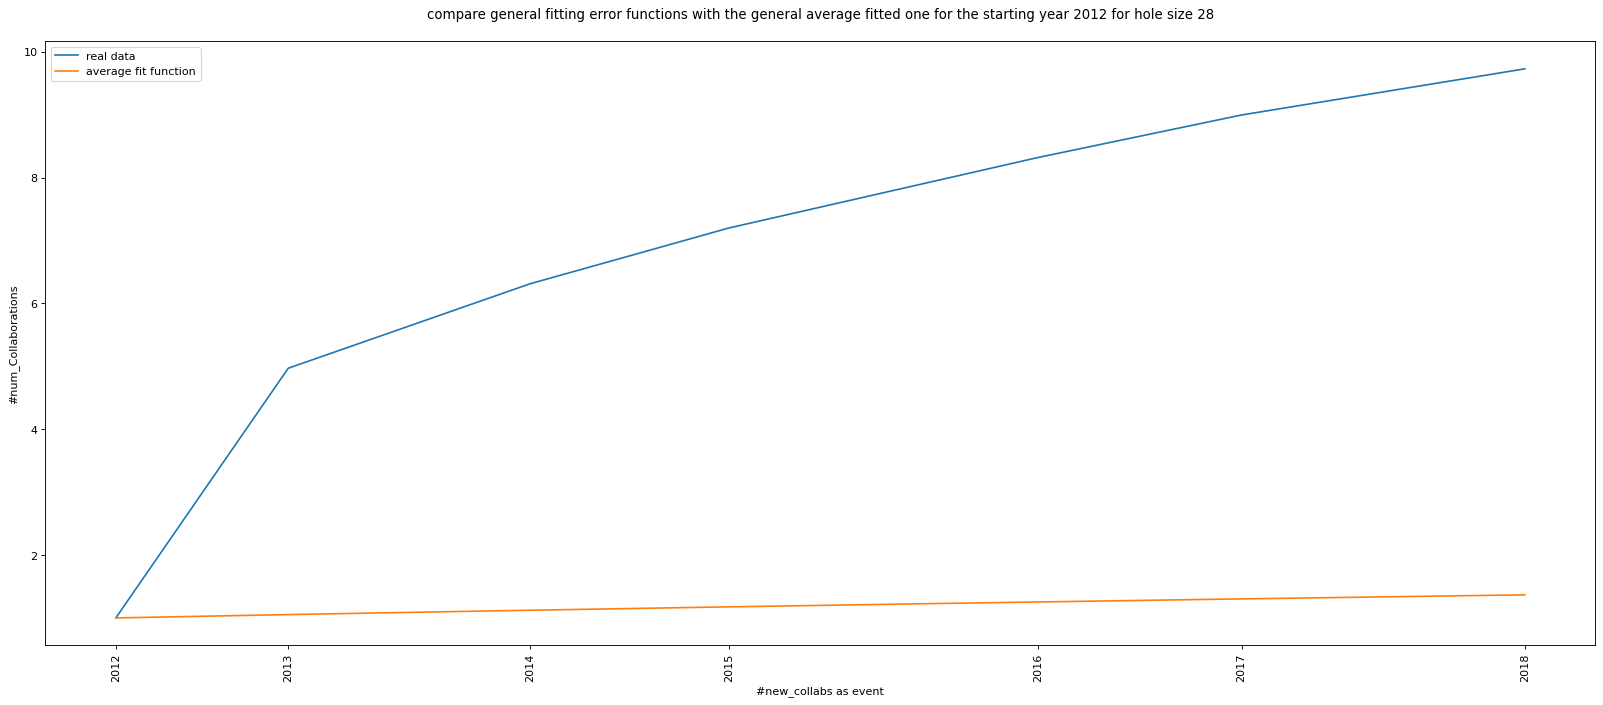

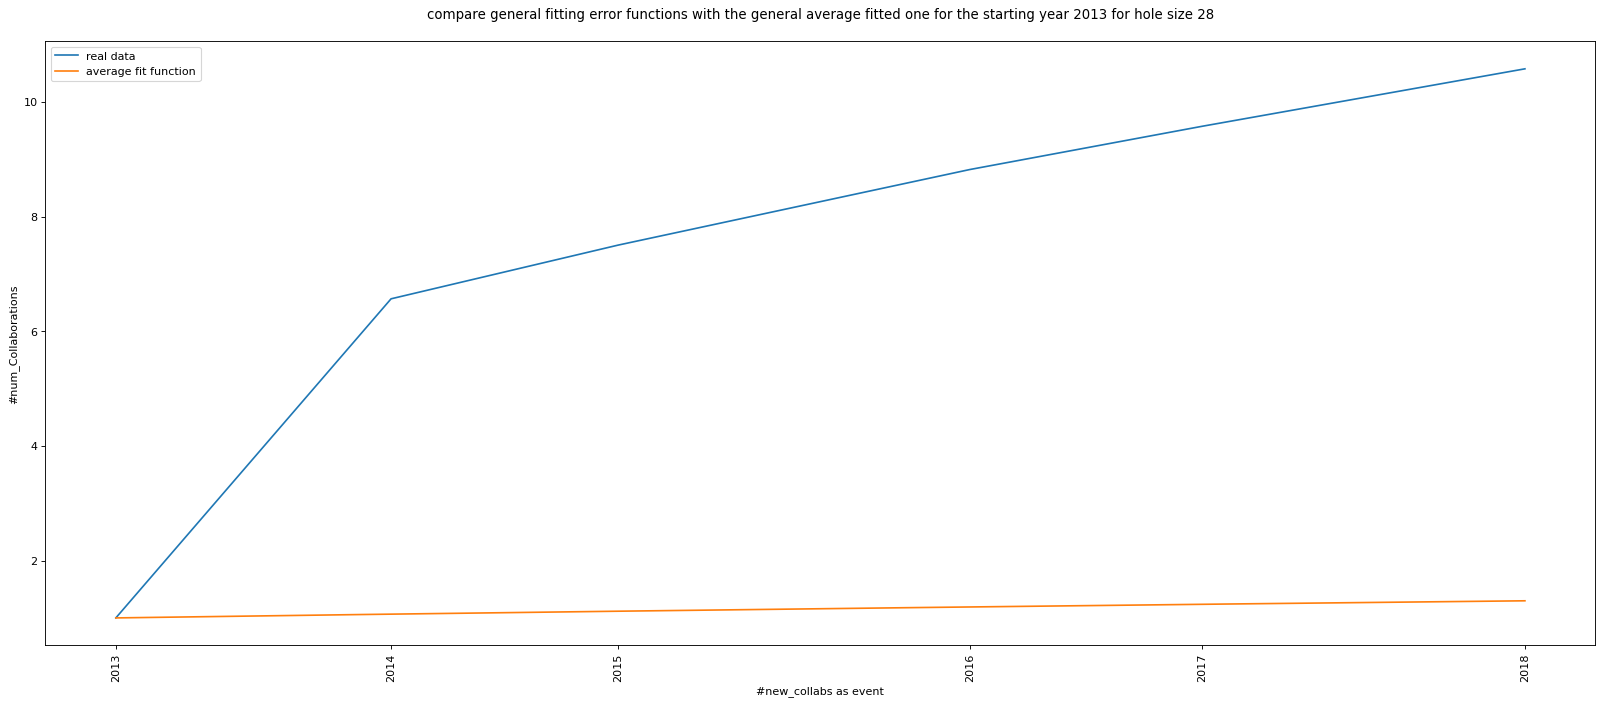

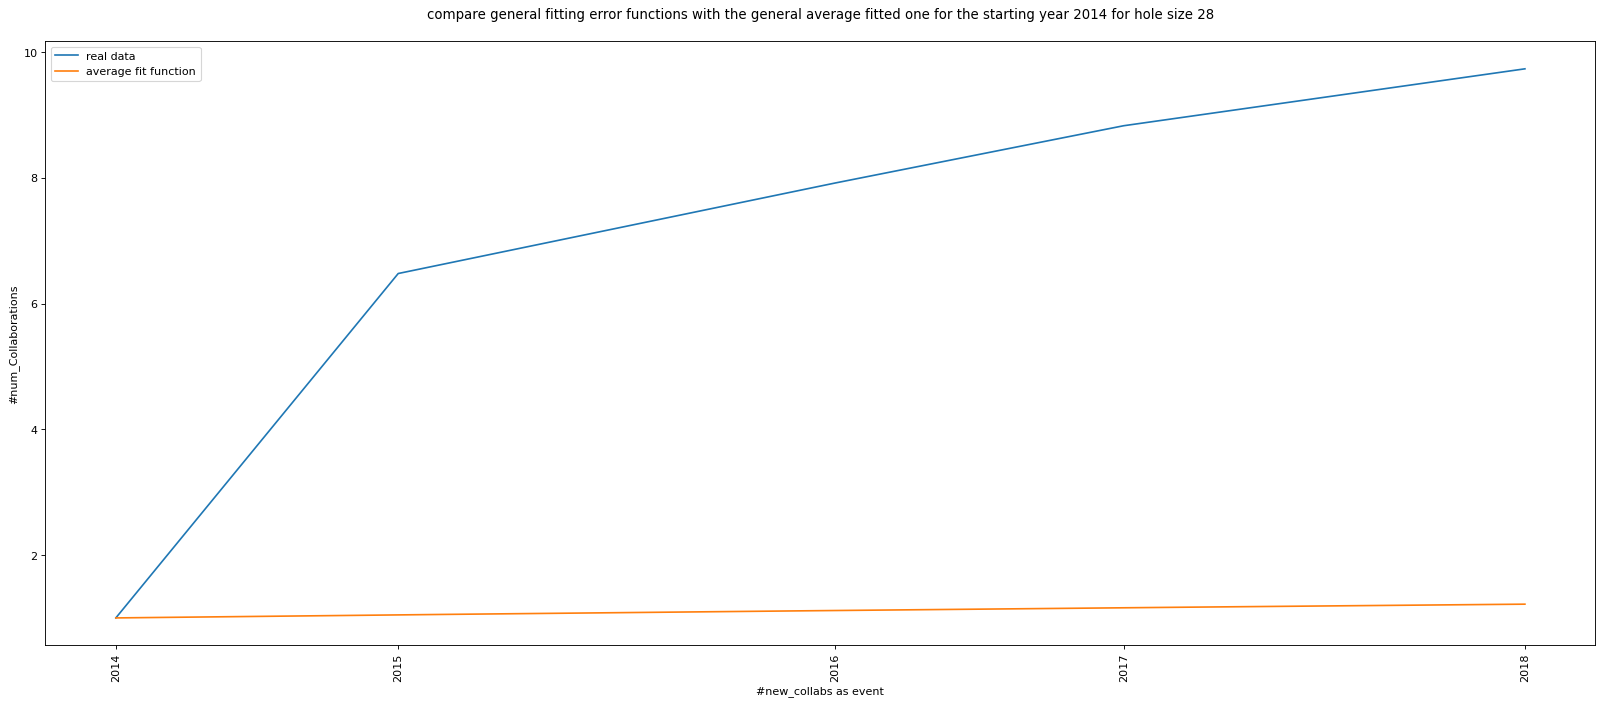

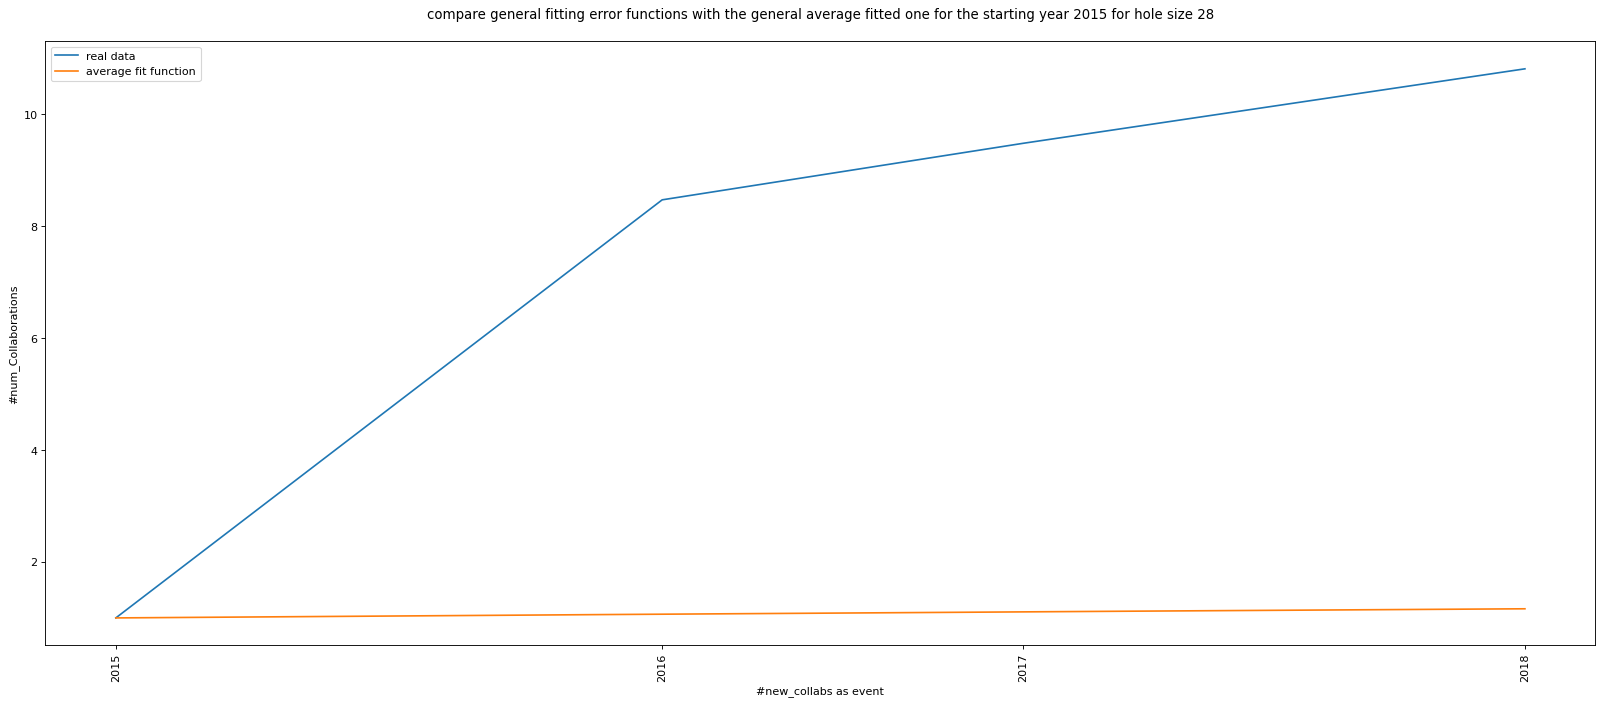

In [13]:
# given the start_y to consider it plots the real curver, the error fitted one and the average fitted toghether 
for start_y in YEARS_TO_CONSIDER:
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("compare general fitting error functions with the general average fitted one for the starting year " + start_y + " for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    j = YEARS_TO_CONSIDER.index(start_y)
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)

    plt.plot(x,y, label="real data")
    
    xdata = [e for e in range(x[0],x[-1])]

    #for i in range(len(error_f_labels)):
    #    plt.plot(xdata, error_fit_functions[error_f_labels[i]][j], label="error fit function "+ error_f_labels[i])

    plt.plot(xdata, average_fit_functions[j], label="average fit function")

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left')
    plt.xticks(x, YEARS[YEARS.index(start_y):])
    plt.show()